In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from darts import TimeSeries
from sklearn.preprocessing import LabelEncoder
from darts import TimeSeries
from darts.models import RegressionModel
from darts.models import LinearRegressionModel
from darts.models import XGBModel
from darts.models import LightGBMModel
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel
from darts import metrics
from darts.metrics import rmse,mse,mae
from functions import preprocessing_data,threshold_filtering_price_optimization,feature_engineering,train_test_split_last_n_rows
import plotly.express as px
import mlflow
from darts.models import TransformerModel
from sklearn.preprocessing import MinMaxScaler
from darts.models import BlockRNNModel
from darts.models import CatBoostModel

In [ ]:
#Data Pipeline

file_path = "merged_dynamic_pricing_data.csv"

# 8d3ea3bc-f65b-4227-9fa6-6fae40e4575a (Mattress)
# 201cb789-4198-488b-a5eb-4e7df0fb4bee (Furniture)
site_id = "8d3ea3bc-f65b-4227-9fa6-6fae40e4575a"

dynamic_pricing_data = pd.read_csv(file_path)

dynamic_pricing_data = preprocessing_data(dynamic_pricing_data, site_id)

threshold_base_price_change = 10
threshold_minimum_sales = 480
threshold_recent_months = 20
threshold_minimum_ratio_of_days_sale_total = 3


dynamic_pricing_data = threshold_filtering_price_optimization(dynamic_pricing_data,threshold_base_price_change,threshold_minimum_sales,threshold_recent_months, 
                                                              threshold_minimum_ratio_of_days_sale_total)


dynamic_pricing_data = feature_engineering(dynamic_pricing_data)


label_encoder=LabelEncoder()

dynamic_pricing_data['product_item_sku_id_encoded'] = label_encoder.fit_transform(dynamic_pricing_data['product_item_sku_id'])




In [ ]:
#Splitting into Train and Test
train,test = train_test_split_last_n_rows(dynamic_pricing_data, 15)

#print(test)
#Converting into time series format for darts
future_covariates_df=pd.concat([train,test],ignore_index=True)
train_time_series=TimeSeries.from_group_dataframe(train,group_cols="product_item_sku_id_encoded",time_col='creation_date',fill_missing_dates=False,freq='D',value_cols=['sales'])
future_covariates_series=TimeSeries.from_group_dataframe(future_covariates_df,group_cols="product_item_sku_id_encoded",time_col='creation_date',fill_missing_dates=False,freq='D',value_cols=['base_price','is_holiday','day_of_week','week_of_month','month_of_year','days_till_black_friday','days_till_christmas','days_till_summer','days_till_winter','is_promotion'])


In [5]:
#Model Pipeline


model=XGBModel(
    lags=[-3,-1],
    lags_future_covariates=[0,1,2,3,4,5,6,7],
    use_static_covariates=False,
    output_chunk_length=1
)


In [6]:
model.fit(series=train_time_series,future_covariates=future_covariates_series)

XGBModel(lags=[-3, -1], lags_past_covariates=None, lags_future_covariates=[0, 1, 2, 3, 4, 5, 6, 7], output_chunk_length=1, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=False)

In [12]:
import math
import xarray as xr

result_df = pd.DataFrame(columns=['sku_id', 'rounded_predictions', 'total_sales'])
result_list=[]
sku_id=0
for sku_id in range(10):
    pred=model.predict(7, series=train_time_series[sku_id],future_covariates=future_covariates_series[sku_id])
    #next 7 predictions
    p = pred.pd_dataframe()
    rounded_predictions = p['sales'].round().astype(int).tolist()
    print(rounded_predictions)
    total_sales = np.sum(rounded_predictions)
    result_list.append((sku_id,rounded_predictions))
    historical_f=model.historical_forecasts(train_time_series[sku_id],start=0.5,forecast_horizon=1,future_covariates=future_covariates_series[sku_id])
    error=model.backtest(train_time_series[sku_id],forecast_horizon=1,stride=1,future_covariates=future_covariates_series[sku_id],metric=rmse,start=0.5,historical_forecasts=historical_f)
    print(error)
    df1=historical_f.pd_dataframe()
    df2=train_time_series[sku_id].pd_dataframe()
    df1['sales']=df1['sales'].round()

    # Assuming both dataframes have a column named 'sales' and a datetime index

    # DataFrame 1 plot
    fig = px.line(df1, x=df1.index, y='sales', title='Sales Over Time',
                labels={'sales': 'Sales', 'index': 'Time'}, line_shape='linear')

    # DataFrame 2 plot on the same figure
    fig.add_scatter(x=df2.index, y=df2['sales'], mode='lines', name='Sales (DataFrame 2)',
                    line=dict(color='red', dash='dash'))

    # Show the plot
    fig.update_layout(width=5000)
    fig.show()

#print(result_list)
# columns = ['creation_date', 'sku_id', 'rounded_predictions']
# df_result = pd.DataFrame(result_list, columns=columns)
# df_result
# print(df_result)



`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


[0, 0, 0, 1, 0, 0, 0]
0.7400459382624331


`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


[0, 0, 1, 0, 0, 0, 0]
0.7555264889437737


`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


[1, 0, 1, 1, 0, 1, 1]
0.7718198690292707


`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


[1, 1, 1, 1, 1, 1, 1]
0.9127768788202014


`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


[1, 1, 1, 1, 0, 0, 0]
1.5924970071177738


`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


[1, 1, 1, 0, 0, 0, 0]
1.506870232940669


`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


[1, 1, 1, 0, 0, 0, 1]
1.5960990251653824


`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


[1, 0, 1, 0, 0, 0, 0]
1.3087027408692062


`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


[1, 1, 1, 2, 1, 0, 1]
0.7950113340407785


`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


[0, 1, 0, 1, 0, 0, 0]
0.6820631950572595


[14:41:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


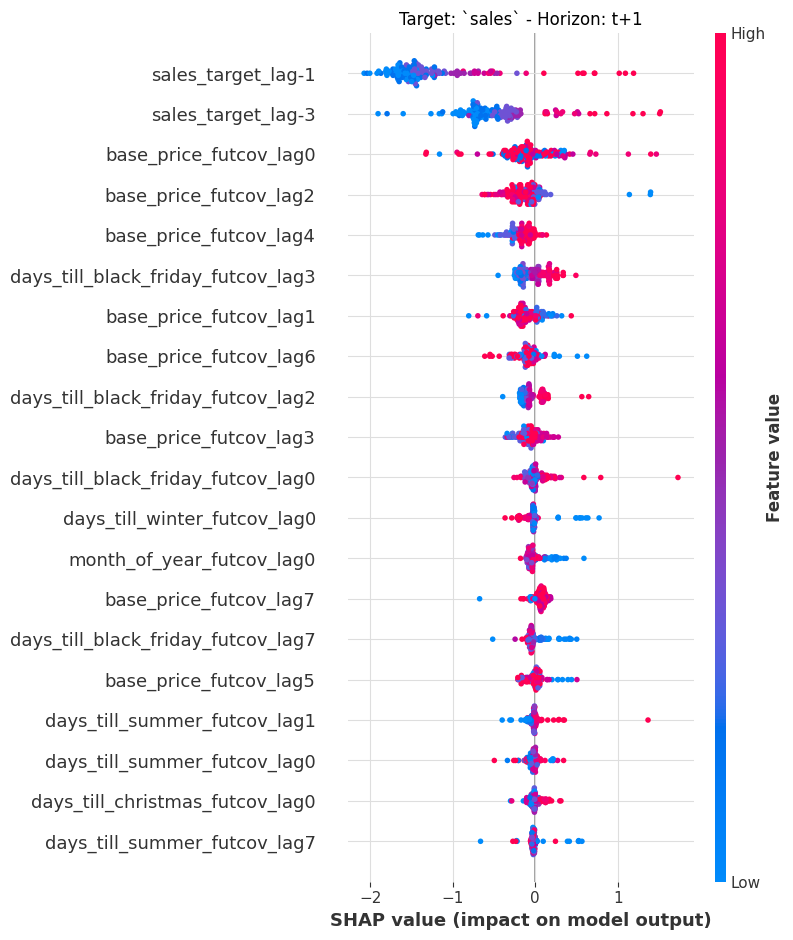

In [87]:

from darts.explainability.shap_explainer import ShapExplainer
shap_explain = ShapExplainer(model,background_series=train_time_series[0],background_future_covariates=future_covariates_series[0])
results = shap_explain.explain()
shap_explain.summary_plot()
shap_explain.force_plot_from_ts()

In [ ]:
#Repeating the above steps for weekly
#Data Pipeline

file_path = "merged_dynamic_pricing_data.csv"

# 8d3ea3bc-f65b-4227-9fa6-6fae40e4575a (Mattress)
# 201cb789-4198-488b-a5eb-4e7df0fb4bee (Furniture)
site_id = "8d3ea3bc-f65b-4227-9fa6-6fae40e4575a"

dynamic_pricing_data = pd.read_csv(file_path)
frequency=7
dynamic_pricing_data = preprocessing_data(dynamic_pricing_data, site_id,7)

threshold_base_price_change = 10
threshold_minimum_sales = 480
threshold_recent_months = 20
threshold_minimum_ratio_of_days_sale_total = 3


dynamic_pricing_data = threshold_filtering_price_optimization(dynamic_pricing_data,threshold_base_price_change,threshold_minimum_sales,threshold_recent_months, 
                                                              threshold_minimum_ratio_of_days_sale_total)


dynamic_pricing_data = feature_engineering(dynamic_pricing_data)


label_encoder=LabelEncoder()

dynamic_pricing_data['product_item_sku_id_encoded'] = label_encoder.fit_transform(dynamic_pricing_data['product_item_sku_id'])

print(dynamic_pricing_data)


In [19]:

#Splitting into Train and Test
train,test = train_test_split_last_n_rows(dynamic_pricing_data, 15)

#print(test)
#Converting into time series format for darts
future_covariates_df=pd.concat([train,test],ignore_index=True)
train_time_series=TimeSeries.from_group_dataframe(train,group_cols="product_item_sku_id_encoded",time_col='creation_date',fill_missing_dates=False,freq='W',value_cols=['sales'])
future_covariates_series=TimeSeries.from_group_dataframe(future_covariates_df,group_cols="product_item_sku_id_encoded",time_col='creation_date',fill_missing_dates=False,freq='W',value_cols=['base_price','is_holiday','day_of_week','week_of_month','month_of_year','days_till_black_friday','days_till_christmas','days_till_summer','days_till_winter','is_promotion'])
past_covariates_series=TimeSeries.from_group_dataframe(future_covariates_df,group_cols="product_item_sku_id_encoded",time_col='creation_date',fill_missing_dates=False,freq='W',value_cols=['base_price','is_holiday','day_of_week','week_of_month','month_of_year','days_till_black_friday','days_till_christmas','days_till_summer','days_till_winter','is_promotion'])
#Model Pipeline

model_params = {
    'lags': [-3],
    'lags_future_covariates': [0],
    'lags_past_covariates': [-3, -7],
    'use_static_covariates': False,
    'output_chunk_length': 1
}

model=XGBModel(**model_params)


model.fit(series=train_time_series,future_covariates=future_covariates_series,past_covariates=past_covariates_series)




XGBModel(lags=[-3], lags_past_covariates=[-3, -7], lags_future_covariates=[0], output_chunk_length=1, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=False)

In [25]:
import math
import xarray as xr

result_df = pd.DataFrame(columns=['sku_id', 'rounded_predictions', 'total_sales'])
result_list=[]
sku_id=0
avg_rmse=0
avg_mae=0
for sku_id in range(10):
    pred=model.predict(1, series=train_time_series[sku_id],future_covariates=future_covariates_series[sku_id],past_covariates=past_covariates_series[sku_id])
    #next 7 predictions
    p = pred.pd_dataframe()
    rounded_predictions = p['sales'].round().astype(int).tolist()
    print(rounded_predictions)
    total_sales = np.sum(rounded_predictions)
    result_list.append((sku_id,rounded_predictions))
    historical_f=model.historical_forecasts(train_time_series[sku_id],start=0.5,forecast_horizon=1,future_covariates=future_covariates_series[sku_id],past_covariates=past_covariates_series[sku_id])
    rmse_error=model.backtest(train_time_series[sku_id],forecast_horizon=1,stride=1,future_covariates=future_covariates_series[sku_id],past_covariates=past_covariates_series[sku_id],metric=rmse,start=0.5,historical_forecasts=historical_f)
    mae_error=model.backtest(train_time_series[sku_id],forecast_horizon=1,stride=1,future_covariates=future_covariates_series[sku_id],past_covariates=past_covariates_series[sku_id],metric=mae,start=0.5,historical_forecasts=historical_f)
    print("Rmse :", rmse_error)
    print("Mae :", mae_error)
    avg_rmse+=rmse_error
    avg_mae+=mae_error
    avg_mse+=mse_error
    
    df1=historical_f.pd_dataframe()
    df2=train_time_series[sku_id].pd_dataframe()
    df1['sales']=df1['sales'].round()

    # Assuming both dataframes have a column named 'sales' and a datetime index

    # DataFrame 1 plot
    fig = px.line(df1, x=df1.index, y='sales', title='Sales Over Time',
                labels={'sales': 'Sales', 'index': 'Time'}, line_shape='linear')

    # DataFrame 2 plot on the same figure
    fig.add_scatter(x=df2.index, y=df2['sales'], mode='lines', name='Sales (DataFrame 2)',
                    line=dict(color='red', dash='dash'))

    # Show the plot
    fig.show()
    
avg_rmse=avg_rmse/10
avg_mae=avg_mae/10
        

#print(result_list)
# columns = ['creation_date', 'sku_id', 'rounded_predictions']
# df_result = pd.DataFrame(result_list, columns=columns)
# df_result
# print(df_result)



`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


[1]
Rmse : 2.7611534884557702
Mae : 2.7611534884557702


`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


[3]
Rmse : 2.3154548712265797
Mae : 2.3154548712265797


`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


[2]
Rmse : 2.491673961486667
Mae : 2.491673961486667


`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


[3]
Rmse : 3.6621437029563824
Mae : 3.6621437029563824


`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


[5]
Rmse : 8.185976551129269
Mae : 8.185976551129269


`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


[9]
Rmse : 6.321977800283676
Mae : 6.321977800283676


`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


[14]
Rmse : 6.433026992357695
Mae : 6.433026992357695


`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


[5]
Rmse : 4.915650821649111
Mae : 4.915650821649111


`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


[1]
Rmse : 3.7209141703415063
Mae : 3.7209141703415063


`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


[6]
Rmse : 3.0996886933795533
Mae : 3.0996886933795533


In [26]:
experiment_name = "XGB experimentation"
experiment_id = mlflow.create_experiment(experiment_name)
run_description="XGBModel Run on weekly Data"
with mlflow.start_run(description=run_description, run_name=run_description,experiment_id=experiment_id):
    # Log XGBModel parameters
    for key, value in model_params.items():
        mlflow.log_param(key, value)
        mlflow.log_metric("rmse",avg_rmse)
        mlflow.log_metric("mae",avg_mae)
        
        
        


In [2]:

#Repeating the above steps for three days
#Data Pipeline

file_path = "merged_dynamic_pricing_data.csv"

# 8d3ea3bc-f65b-4227-9fa6-6fae40e4575a (Mattress)
# 201cb789-4198-488b-a5eb-4e7df0fb4bee (Furniture)
site_id = "8d3ea3bc-f65b-4227-9fa6-6fae40e4575a"

dynamic_pricing_data = pd.read_csv(file_path)
frequency=3
dynamic_pricing_data = preprocessing_data(dynamic_pricing_data, site_id,3)

threshold_base_price_change = 10
threshold_minimum_sales = 480
threshold_recent_months = 20
threshold_minimum_ratio_of_days_sale_total = 3


dynamic_pricing_data = threshold_filtering_price_optimization(dynamic_pricing_data,threshold_base_price_change,threshold_minimum_sales,threshold_recent_months, 
                                                              threshold_minimum_ratio_of_days_sale_total)


dynamic_pricing_data = feature_engineering(dynamic_pricing_data)


label_encoder=LabelEncoder()

dynamic_pricing_data['product_item_sku_id_encoded'] = label_encoder.fit_transform(dynamic_pricing_data['product_item_sku_id'])

#print(dynamic_pricing_data)


C:\Users\HP\AppData\Local\Temp\ipykernel_20432\1128728115.py:10: DtypeWarning: Columns (20,50,52) have mixed types. Specify dtype option on import or set low_memory=False.
  dynamic_pricing_data = pd.read_csv(file_path)
c:\Users\HP\Documents\Fyp_experimentation\Darts_Experimentation\functions.py:198: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['creation_date'] = pd.to_datetime(


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3679 entries, 0 to 3678
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   creation_date        3679 non-null   datetime64[ns]
 1   product_item_sku_id  3679 non-null   object        
 2   sales                3679 non-null   int64         
 3   base_price           3679 non-null   float64       
 4   list_price           3679 non-null   float64       
 5   sale_price           3631 non-null   float64       
 6   msrp                 3679 non-null   float64       
 7   views                3679 non-null   float64       
 8   cart_quantity        3679 non-null   float64       
 9   base_price_change    3679 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(6), int64(1), object(1)
memory usage: 262.4+ KB


In [34]:

#Splitting into Train and Test
train,test = train_test_split_last_n_rows(dynamic_pricing_data, 15)

#print(test)
#Converting into time series format for darts
future_covariates_df=pd.concat([train,test],ignore_index=True)
train_time_series=TimeSeries.from_group_dataframe(train,group_cols="product_item_sku_id_encoded",time_col='creation_date',fill_missing_dates=False,freq='3D',value_cols=['sales'])
future_covariates_series=TimeSeries.from_group_dataframe(future_covariates_df,group_cols="product_item_sku_id_encoded",time_col='creation_date',fill_missing_dates=False,freq='3D',value_cols=['base_price','is_holiday','day_of_week','week_of_month','month_of_year','days_till_black_friday','days_till_christmas','days_till_summer','days_till_winter','is_promotion'])
past_covariates_series=TimeSeries.from_group_dataframe(future_covariates_df,group_cols="product_item_sku_id_encoded",time_col='creation_date',fill_missing_dates=False,freq='3D',value_cols=['base_price','is_holiday','day_of_week','week_of_month','month_of_year','days_till_black_friday','days_till_christmas','days_till_summer','days_till_winter','is_promotion'])
#Model Pipeline


model_params = {
    'model': "LSTM",
    'batch_size': 100,
    'n_epochs': 100,
    'output_chunk_length': 1,
    'input_chunk_length':125,
    'training_length':126
    
}

model=RNNmodel(**model_params)


model.fit(series=train_time_series,future_covariates=future_covariates_series)




ImportError: The `LightGBM` module could not be imported. To enable LightGBM support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md


ImportError: The `LightGBM` module could not be imported. To enable LightGBM support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md

In [31]:
import math
import xarray as xr



result_df = pd.DataFrame(columns=['sku_id', 'rounded_predictions', 'total_sales'])
result_list=[]
sku_id=0
avg_rmse=0
avg_mae=0
for sku_id in range(10):
    pred=model.predict(1, series=train_time_series[sku_id],future_covariates=future_covariates_series[sku_id])
    #next 7 predictions
    p = pred.pd_dataframe()
    rounded_predictions = p['sales'].round().astype(int).tolist()
    print(rounded_predictions)
    total_sales = np.sum(rounded_predictions)
    result_list.append((sku_id,rounded_predictions))
    historical_f=model.historical_forecasts(train_time_series[sku_id],start=0.5,forecast_horizon=1,future_covariates=future_covariates_series[sku_id],retrain=False)
    rmse_error=model.backtest(train_time_series[sku_id],forecast_horizon=1,stride=1,future_covariates=future_covariates_series[sku_id],metric=rmse,start=0.5,historical_forecasts=historical_f,retrain=True)
    mae_error=model.backtest(train_time_series[sku_id],forecast_horizon=1,stride=1,future_covariates=future_covariates_series[sku_id],metric=mae,start=0.5,historical_forecasts=historical_f,retrain=True)
    print("Rmse :", rmse_error)
    print("Mae :", mae_error)
    avg_rmse+=rmse_error
    avg_mae+=mae_error
    
    df1=historical_f.pd_dataframe()
    df2=train_time_series[sku_id].pd_dataframe()
    df1['sales']=df1['sales'].round()

    # Assuming both dataframes have a column named 'sales' and a datetime index

    # DataFrame 1 plot
    fig = px.line(df1, x=df1.index, y='sales', title='Sales Over Time',
                labels={'sales': 'Sales', 'index': 'Time'}, line_shape='linear')

    # DataFrame 2 plot on the same figure
    fig.add_scatter(x=df2.index, y=df2['sales'], mode='lines', name='Sales (DataFrame 2)',
                    line=dict(color='red', dash='dash'))

    # Show the plot
    fig.update_layout(width=5000)
    fig.show()
    
avg_rmse=avg_rmse/10
avg_mae=avg_mae/10
        

#print(result_list)
# columns = ['creation_date', 'sku_id', 'rounded_predictions']
# df_result = pd.DataFrame(result_list, columns=columns)
# df_result
# print(df_result)





GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[1]
Rmse : 1.2774232871803661
Mae : 1.2774232871803661


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[2]
Rmse : 1.3572152947505316
Mae : 1.3572152947505316


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

`start` value `0.5` corresponding to timestamp `2021-08-02 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Ignoring `start` for this series and beginning at first trainable/predictable time: 2021-08-08 00:00:00. To hide these warnings, set `show_warnings=False`.


[1]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Rmse : 1.1751813943663068
Mae : 1.1751813943663068


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

`start` value `0.5` corresponding to timestamp `2021-08-06 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Ignoring `start` for this series and beginning at first trainable/predictable time: 2021-08-12 00:00:00. To hide these warnings, set `show_warnings=False`.


[1]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Rmse : 1.6008482838849432
Mae : 1.6008482838849432


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

[3]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Rmse : 2.6322541775674035
Mae : 2.6322541775674035


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[2]
Rmse : 2.3724937635439
Mae : 2.3724937635439


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

[3]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Rmse : 2.4590119889914117
Mae : 2.4590119889914117


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

[3]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Rmse : 1.880435883522726
Mae : 1.880435883522726


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False


[2]


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Rmse : 1.5115822715310536
Mae : 1.5115822715310536


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

[0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Rmse : 1.2032994431698667
Mae : 1.2032994431698667


In [21]:
run_description="RNN LSTM Run on three days data after changing input size length, way worse results in the charts"
with mlflow.start_run(description=run_description, run_name=run_description,experiment_id=497156172791036355):
    # Log XGBModel parameters
    for key, value in model_params.items():
        mlflow.log_param(key, value)
        mlflow.log_metric("rmse",avg_rmse)
        mlflow.log_metric("mae",avg_mae)
        
        
        


In [4]:

#Splitting into Train and Test
train,test = train_test_split_last_n_rows(dynamic_pricing_data, 15)

#print(test)
#Converting into time series format for darts
future_covariates_df=pd.concat([train,test],ignore_index=True)
train_time_series=TimeSeries.from_group_dataframe(train,group_cols="product_item_sku_id_encoded",time_col='creation_date',fill_missing_dates=False,freq='3D',value_cols=['sales'])
future_covariates_series=TimeSeries.from_group_dataframe(future_covariates_df,group_cols="product_item_sku_id_encoded",time_col='creation_date',fill_missing_dates=False,freq='3D',value_cols=['base_price','is_holiday','day_of_week','week_of_month','month_of_year','days_till_black_friday','days_till_christmas','days_till_summer','days_till_winter','is_promotion'])
past_covariates_series=TimeSeries.from_group_dataframe(future_covariates_df,group_cols="product_item_sku_id_encoded",time_col='creation_date',fill_missing_dates=False,freq='3D',value_cols=['base_price','is_holiday','day_of_week','week_of_month','month_of_year','days_till_black_friday','days_till_christmas','days_till_summer','days_till_winter','is_promotion'])
#Model Pipeline


model_params = {
    'batch_size': 100,
    'n_epochs': 50,
    'output_chunk_length': 1,
    'input_chunk_length':125
    
}

model=BlockRNNModel(**model_params)


model.fit(series=train_time_series,past_covariates=past_covariates_series)




GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 950   
4 | fc            | Sequential       | 26    
---------------------------------------------------
976       Trainable params
0         Non-trainable params
976       Total params
0.004     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


BlockRNNModel(model=RNN, hidden_dim=25, n_rnn_layers=1, hidden_fc_sizes=None, dropout=0.0, batch_size=100, n_epochs=50, output_chunk_length=1, input_chunk_length=125)

In [8]:
import math
import plotly.offline as pyo
import plotly.graph_objs as go
import xarray as xr



result_df = pd.DataFrame(columns=['sku_id', 'rounded_predictions', 'total_sales'])
result_list=[]
plot_list = []
sku_id=0
avg_rmse=0
avg_mae=0
for sku_id in range(10):
    pred=model.predict(1, series=train_time_series[sku_id],past_covariates=past_covariates_series[sku_id])
    #next 7 predictions
    p = pred.pd_dataframe()
    rounded_predictions = p['sales'].round().astype(int).tolist()
    print(rounded_predictions)
    total_sales = np.sum(rounded_predictions)
    result_list.append((sku_id,rounded_predictions))
    historical_f=model.historical_forecasts(train_time_series[sku_id],start=0.5,forecast_horizon=1,past_covariates=past_covariates_series[sku_id],retrain=False)
    rmse_error=model.backtest(train_time_series[sku_id],forecast_horizon=1,stride=1,past_covariates=past_covariates_series[sku_id],metric=rmse,start=0.5,historical_forecasts=historical_f,retrain=True)
    mae_error=model.backtest(train_time_series[sku_id],forecast_horizon=1,stride=1,past_covariates=past_covariates_series[sku_id],metric=mae,start=0.5,historical_forecasts=historical_f,retrain=True)
    print("Rmse :", rmse_error)
    print("Mae :", mae_error)
    avg_rmse+=rmse_error
    avg_mae+=mae_error
    
    df1=historical_f.pd_dataframe()
    df2=train_time_series[sku_id].pd_dataframe()
    df1['sales']=df1['sales'].round()

    # Assuming both dataframes have a column named 'sales' and a datetime index

    # DataFrame 1 plot
    fig = px.line(df1, x=df1.index, y='sales', title='Sales Over Time',
                labels={'sales': 'Sales', 'index': 'Time'}, line_shape='linear')

    # DataFrame 2 plot on the same figure
    fig.add_scatter(x=df2.index, y=df2['sales'], mode='lines', name='Sales (DataFrame 2)',
                    line=dict(color='red', dash='dash'))

    # Show the plot
    fig.update_layout(width=5000)
    fig.show()
    plot_list.append(fig)
    
avg_rmse=avg_rmse/10
avg_mae=avg_mae/10



#print(result_list)
# columns = ['creation_date', 'sku_id', 'rounded_predictions']
# df_result = pd.DataFrame(result_list, columns=columns)
# df_result
# print(df_result)





GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[2]
Rmse : 1.2808773548765677
Mae : 1.2808773548765677


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False


[2]


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Rmse : 1.4155997871000832
Mae : 1.4155997871000832


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

`start` value `0.5` corresponding to timestamp `2021-08-02 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Ignoring `start` for this series and beginning at first trainable/predictable time: 2021-08-08 00:00:00. To hide these warnings, set `show_warnings=False`.


[2]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Rmse : 1.3499836431341545
Mae : 1.3499836431341545


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

`start` value `0.5` corresponding to timestamp `2021-08-06 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Ignoring `start` for this series and beginning at first trainable/predictable time: 2021-08-12 00:00:00. To hide these warnings, set `show_warnings=False`.


[2]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Rmse : 1.6391535019371362
Mae : 1.6391535019371362


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

[3]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Rmse : 2.6269492100608156
Mae : 2.6269492100608156


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

[3]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Rmse : 2.409029035202298
Mae : 2.409029035202298


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[3]
Rmse : 2.645580991446309
Mae : 2.645580991446309


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False


[3]


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Rmse : 2.196930366536108
Mae : 2.196930366536108


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[3]
Rmse : 2.313860796441425
Mae : 2.313860796441425


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

[3]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Rmse : 2.2269382435799425
Mae : 2.2269382435799425


ValueError: 
    Invalid element(s) received for the 'data' property of 
        Invalid elements include: [Figure({
    'data': [{'hovertemplate': 'time=%{x}<br>Sales=%{y}<extra></extra>',
              'legendgroup': '',
              'line': {'color': '#636efa', 'dash': 'solid', 'shape': 'linear'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': '',
              'orientation': 'v',
              'showlegend': False,
              'type': 'scatter',
              'x': array([datetime.datetime(2022, 2, 17, 0, 0),
                          datetime.datetime(2022, 2, 20, 0, 0),
                          datetime.datetime(2022, 2, 23, 0, 0),
                          datetime.datetime(2022, 2, 26, 0, 0),
                          datetime.datetime(2022, 3, 1, 0, 0),
                          datetime.datetime(2022, 3, 4, 0, 0),
                          datetime.datetime(2022, 3, 7, 0, 0),
                          datetime.datetime(2022, 3, 10, 0, 0),
                          datetime.datetime(2022, 3, 13, 0, 0),
                          datetime.datetime(2022, 3, 16, 0, 0),
                          datetime.datetime(2022, 3, 19, 0, 0),
                          datetime.datetime(2022, 3, 22, 0, 0),
                          datetime.datetime(2022, 3, 25, 0, 0),
                          datetime.datetime(2022, 3, 28, 0, 0),
                          datetime.datetime(2022, 3, 31, 0, 0),
                          datetime.datetime(2022, 4, 3, 0, 0),
                          datetime.datetime(2022, 4, 6, 0, 0),
                          datetime.datetime(2022, 4, 9, 0, 0),
                          datetime.datetime(2022, 4, 12, 0, 0),
                          datetime.datetime(2022, 4, 15, 0, 0),
                          datetime.datetime(2022, 4, 18, 0, 0),
                          datetime.datetime(2022, 4, 21, 0, 0),
                          datetime.datetime(2022, 4, 24, 0, 0),
                          datetime.datetime(2022, 4, 27, 0, 0),
                          datetime.datetime(2022, 4, 30, 0, 0),
                          datetime.datetime(2022, 5, 3, 0, 0),
                          datetime.datetime(2022, 5, 6, 0, 0),
                          datetime.datetime(2022, 5, 9, 0, 0),
                          datetime.datetime(2022, 5, 12, 0, 0),
                          datetime.datetime(2022, 5, 15, 0, 0),
                          datetime.datetime(2022, 5, 18, 0, 0),
                          datetime.datetime(2022, 5, 21, 0, 0),
                          datetime.datetime(2022, 5, 24, 0, 0),
                          datetime.datetime(2022, 5, 27, 0, 0),
                          datetime.datetime(2022, 5, 30, 0, 0),
                          datetime.datetime(2022, 6, 2, 0, 0),
                          datetime.datetime(2022, 6, 5, 0, 0),
                          datetime.datetime(2022, 6, 8, 0, 0),
                          datetime.datetime(2022, 6, 11, 0, 0),
                          datetime.datetime(2022, 6, 14, 0, 0),
                          datetime.datetime(2022, 6, 17, 0, 0),
                          datetime.datetime(2022, 6, 20, 0, 0),
                          datetime.datetime(2022, 6, 23, 0, 0),
                          datetime.datetime(2022, 6, 26, 0, 0),
                          datetime.datetime(2022, 6, 29, 0, 0),
                          datetime.datetime(2022, 7, 2, 0, 0),
                          datetime.datetime(2022, 7, 5, 0, 0),
                          datetime.datetime(2022, 7, 8, 0, 0),
                          datetime.datetime(2022, 7, 11, 0, 0),
                          datetime.datetime(2022, 7, 14, 0, 0),
                          datetime.datetime(2022, 7, 17, 0, 0),
                          datetime.datetime(2022, 7, 20, 0, 0),
                          datetime.datetime(2022, 7, 23, 0, 0),
                          datetime.datetime(2022, 7, 26, 0, 0),
                          datetime.datetime(2022, 7, 29, 0, 0),
                          datetime.datetime(2022, 8, 1, 0, 0),
                          datetime.datetime(2022, 8, 4, 0, 0),
                          datetime.datetime(2022, 8, 7, 0, 0),
                          datetime.datetime(2022, 8, 10, 0, 0),
                          datetime.datetime(2022, 8, 13, 0, 0),
                          datetime.datetime(2022, 8, 16, 0, 0),
                          datetime.datetime(2022, 8, 19, 0, 0),
                          datetime.datetime(2022, 8, 22, 0, 0),
                          datetime.datetime(2022, 8, 25, 0, 0),
                          datetime.datetime(2022, 8, 28, 0, 0),
                          datetime.datetime(2022, 8, 31, 0, 0),
                          datetime.datetime(2022, 9, 3, 0, 0),
                          datetime.datetime(2022, 9, 6, 0, 0),
                          datetime.datetime(2022, 9, 9, 0, 0),
                          datetime.datetime(2022, 9, 12, 0, 0),
                          datetime.datetime(2022, 9, 15, 0, 0),
                          datetime.datetime(2022, 9, 18, 0, 0),
                          datetime.datetime(2022, 9, 21, 0, 0),
                          datetime.datetime(2022, 9, 24, 0, 0),
                          datetime.datetime(2022, 9, 27, 0, 0),
                          datetime.datetime(2022, 9, 30, 0, 0),
                          datetime.datetime(2022, 10, 3, 0, 0),
                          datetime.datetime(2022, 10, 6, 0, 0),
                          datetime.datetime(2022, 10, 9, 0, 0),
                          datetime.datetime(2022, 10, 12, 0, 0),
                          datetime.datetime(2022, 10, 15, 0, 0),
                          datetime.datetime(2022, 10, 18, 0, 0),
                          datetime.datetime(2022, 10, 21, 0, 0),
                          datetime.datetime(2022, 10, 24, 0, 0),
                          datetime.datetime(2022, 10, 27, 0, 0),
                          datetime.datetime(2022, 10, 30, 0, 0),
                          datetime.datetime(2022, 11, 2, 0, 0),
                          datetime.datetime(2022, 11, 5, 0, 0),
                          datetime.datetime(2022, 11, 8, 0, 0),
                          datetime.datetime(2022, 11, 11, 0, 0),
                          datetime.datetime(2022, 11, 14, 0, 0),
                          datetime.datetime(2022, 11, 17, 0, 0),
                          datetime.datetime(2022, 11, 20, 0, 0),
                          datetime.datetime(2022, 11, 23, 0, 0),
                          datetime.datetime(2022, 11, 26, 0, 0),
                          datetime.datetime(2022, 11, 29, 0, 0),
                          datetime.datetime(2022, 12, 2, 0, 0),
                          datetime.datetime(2022, 12, 5, 0, 0),
                          datetime.datetime(2022, 12, 8, 0, 0),
                          datetime.datetime(2022, 12, 11, 0, 0),
                          datetime.datetime(2022, 12, 14, 0, 0),
                          datetime.datetime(2022, 12, 17, 0, 0),
                          datetime.datetime(2022, 12, 20, 0, 0),
                          datetime.datetime(2022, 12, 23, 0, 0),
                          datetime.datetime(2022, 12, 26, 0, 0),
                          datetime.datetime(2022, 12, 29, 0, 0),
                          datetime.datetime(2023, 1, 1, 0, 0),
                          datetime.datetime(2023, 1, 4, 0, 0),
                          datetime.datetime(2023, 1, 7, 0, 0),
                          datetime.datetime(2023, 1, 10, 0, 0),
                          datetime.datetime(2023, 1, 13, 0, 0),
                          datetime.datetime(2023, 1, 16, 0, 0),
                          datetime.datetime(2023, 1, 19, 0, 0),
                          datetime.datetime(2023, 1, 22, 0, 0),
                          datetime.datetime(2023, 1, 25, 0, 0),
                          datetime.datetime(2023, 1, 28, 0, 0),
                          datetime.datetime(2023, 1, 31, 0, 0),
                          datetime.datetime(2023, 2, 3, 0, 0),
                          datetime.datetime(2023, 2, 6, 0, 0),
                          datetime.datetime(2023, 2, 9, 0, 0),
                          datetime.datetime(2023, 2, 12, 0, 0),
                          datetime.datetime(2023, 2, 15, 0, 0),
                          datetime.datetime(2023, 2, 18, 0, 0),
                          datetime.datetime(2023, 2, 21, 0, 0),
                          datetime.datetime(2023, 2, 24, 0, 0),
                          datetime.datetime(2023, 2, 27, 0, 0),
                          datetime.datetime(2023, 3, 2, 0, 0),
                          datetime.datetime(2023, 3, 5, 0, 0),
                          datetime.datetime(2023, 3, 8, 0, 0),
                          datetime.datetime(2023, 3, 11, 0, 0),
                          datetime.datetime(2023, 3, 14, 0, 0),
                          datetime.datetime(2023, 3, 17, 0, 0),
                          datetime.datetime(2023, 3, 20, 0, 0),
                          datetime.datetime(2023, 3, 23, 0, 0),
                          datetime.datetime(2023, 3, 26, 0, 0),
                          datetime.datetime(2023, 3, 29, 0, 0),
                          datetime.datetime(2023, 4, 1, 0, 0),
                          datetime.datetime(2023, 4, 4, 0, 0),
                          datetime.datetime(2023, 4, 7, 0, 0),
                          datetime.datetime(2023, 4, 10, 0, 0),
                          datetime.datetime(2023, 4, 13, 0, 0),
                          datetime.datetime(2023, 4, 16, 0, 0),
                          datetime.datetime(2023, 4, 19, 0, 0),
                          datetime.datetime(2023, 4, 22, 0, 0),
                          datetime.datetime(2023, 4, 25, 0, 0),
                          datetime.datetime(2023, 4, 28, 0, 0),
                          datetime.datetime(2023, 5, 1, 0, 0),
                          datetime.datetime(2023, 5, 4, 0, 0),
                          datetime.datetime(2023, 5, 7, 0, 0),
                          datetime.datetime(2023, 5, 10, 0, 0),
                          datetime.datetime(2023, 5, 13, 0, 0),
                          datetime.datetime(2023, 5, 16, 0, 0),
                          datetime.datetime(2023, 5, 19, 0, 0),
                          datetime.datetime(2023, 5, 22, 0, 0),
                          datetime.datetime(2023, 5, 25, 0, 0),
                          datetime.datetime(2023, 5, 28, 0, 0),
                          datetime.datetime(2023, 5, 31, 0, 0),
                          datetime.datetime(2023, 6, 3, 0, 0),
                          datetime.datetime(2023, 6, 6, 0, 0),
                          datetime.datetime(2023, 6, 9, 0, 0),
                          datetime.datetime(2023, 6, 12, 0, 0),
                          datetime.datetime(2023, 6, 15, 0, 0),
                          datetime.datetime(2023, 6, 18, 0, 0),
                          datetime.datetime(2023, 6, 21, 0, 0),
                          datetime.datetime(2023, 6, 24, 0, 0),
                          datetime.datetime(2023, 6, 27, 0, 0),
                          datetime.datetime(2023, 6, 30, 0, 0),
                          datetime.datetime(2023, 7, 3, 0, 0),
                          datetime.datetime(2023, 7, 6, 0, 0),
                          datetime.datetime(2023, 7, 9, 0, 0),
                          datetime.datetime(2023, 7, 12, 0, 0),
                          datetime.datetime(2023, 7, 15, 0, 0),
                          datetime.datetime(2023, 7, 18, 0, 0),
                          datetime.datetime(2023, 7, 21, 0, 0),
                          datetime.datetime(2023, 7, 24, 0, 0),
                          datetime.datetime(2023, 7, 27, 0, 0),
                          datetime.datetime(2023, 7, 30, 0, 0),
                          datetime.datetime(2023, 8, 2, 0, 0),
                          datetime.datetime(2023, 8, 5, 0, 0),
                          datetime.datetime(2023, 8, 8, 0, 0),
                          datetime.datetime(2023, 8, 11, 0, 0),
                          datetime.datetime(2023, 8, 14, 0, 0),
                          datetime.datetime(2023, 8, 17, 0, 0),
                          datetime.datetime(2023, 8, 20, 0, 0),
                          datetime.datetime(2023, 8, 23, 0, 0),
                          datetime.datetime(2023, 8, 26, 0, 0),
                          datetime.datetime(2023, 8, 29, 0, 0),
                          datetime.datetime(2023, 9, 1, 0, 0),
                          datetime.datetime(2023, 9, 4, 0, 0),
                          datetime.datetime(2023, 9, 7, 0, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
                          2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
                          2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
                          2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
                          2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 3., 3.,
                          4., 4., 4., 4., 4., 4., 4., 2., 2., 2., 2., 2., 2., 2., 2., 3., 3., 2.,
                          2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
                          2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
                          2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
                          2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
                          2., 2., 2., 2., 2., 2., 2., 2., 2., 2.]),
              'yaxis': 'y'},
             {'line': {'color': 'red', 'dash': 'dash'},
              'mode': 'lines',
              'name': 'Sales (DataFrame 2)',
              'type': 'scatter',
              'x': array([datetime.datetime(2020, 8, 2, 0, 0),
                          datetime.datetime(2020, 8, 5, 0, 0),
                          datetime.datetime(2020, 8, 8, 0, 0), ...,
                          datetime.datetime(2023, 9, 1, 0, 0),
                          datetime.datetime(2023, 9, 4, 0, 0),
                          datetime.datetime(2023, 9, 7, 0, 0)], dtype=object),
              'y': array([4., 0., 2., ..., 1., 4., 1.])}],
    'layout': {'legend': {'tracegroupgap': 0},
               'template': '...',
               'title': {'text': 'Sales Over Time'},
               'width': 5000,
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'time'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'Sales'}}}
}), Figure({
    'data': [{'hovertemplate': 'time=%{x}<br>Sales=%{y}<extra></extra>',
              'legendgroup': '',
              'line': {'color': '#636efa', 'dash': 'solid', 'shape': 'linear'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': '',
              'orientation': 'v',
              'showlegend': False,
              'type': 'scatter',
              'x': array([datetime.datetime(2022, 2, 17, 0, 0),
                          datetime.datetime(2022, 2, 20, 0, 0),
                          datetime.datetime(2022, 2, 23, 0, 0),
                          datetime.datetime(2022, 2, 26, 0, 0),
                          datetime.datetime(2022, 3, 1, 0, 0),
                          datetime.datetime(2022, 3, 4, 0, 0),
                          datetime.datetime(2022, 3, 7, 0, 0),
                          datetime.datetime(2022, 3, 10, 0, 0),
                          datetime.datetime(2022, 3, 13, 0, 0),
                          datetime.datetime(2022, 3, 16, 0, 0),
                          datetime.datetime(2022, 3, 19, 0, 0),
                          datetime.datetime(2022, 3, 22, 0, 0),
                          datetime.datetime(2022, 3, 25, 0, 0),
                          datetime.datetime(2022, 3, 28, 0, 0),
                          datetime.datetime(2022, 3, 31, 0, 0),
                          datetime.datetime(2022, 4, 3, 0, 0),
                          datetime.datetime(2022, 4, 6, 0, 0),
                          datetime.datetime(2022, 4, 9, 0, 0),
                          datetime.datetime(2022, 4, 12, 0, 0),
                          datetime.datetime(2022, 4, 15, 0, 0),
                          datetime.datetime(2022, 4, 18, 0, 0),
                          datetime.datetime(2022, 4, 21, 0, 0),
                          datetime.datetime(2022, 4, 24, 0, 0),
                          datetime.datetime(2022, 4, 27, 0, 0),
                          datetime.datetime(2022, 4, 30, 0, 0),
                          datetime.datetime(2022, 5, 3, 0, 0),
                          datetime.datetime(2022, 5, 6, 0, 0),
                          datetime.datetime(2022, 5, 9, 0, 0),
                          datetime.datetime(2022, 5, 12, 0, 0),
                          datetime.datetime(2022, 5, 15, 0, 0),
                          datetime.datetime(2022, 5, 18, 0, 0),
                          datetime.datetime(2022, 5, 21, 0, 0),
                          datetime.datetime(2022, 5, 24, 0, 0),
                          datetime.datetime(2022, 5, 27, 0, 0),
                          datetime.datetime(2022, 5, 30, 0, 0),
                          datetime.datetime(2022, 6, 2, 0, 0),
                          datetime.datetime(2022, 6, 5, 0, 0),
                          datetime.datetime(2022, 6, 8, 0, 0),
                          datetime.datetime(2022, 6, 11, 0, 0),
                          datetime.datetime(2022, 6, 14, 0, 0),
                          datetime.datetime(2022, 6, 17, 0, 0),
                          datetime.datetime(2022, 6, 20, 0, 0),
                          datetime.datetime(2022, 6, 23, 0, 0),
                          datetime.datetime(2022, 6, 26, 0, 0),
                          datetime.datetime(2022, 6, 29, 0, 0),
                          datetime.datetime(2022, 7, 2, 0, 0),
                          datetime.datetime(2022, 7, 5, 0, 0),
                          datetime.datetime(2022, 7, 8, 0, 0),
                          datetime.datetime(2022, 7, 11, 0, 0),
                          datetime.datetime(2022, 7, 14, 0, 0),
                          datetime.datetime(2022, 7, 17, 0, 0),
                          datetime.datetime(2022, 7, 20, 0, 0),
                          datetime.datetime(2022, 7, 23, 0, 0),
                          datetime.datetime(2022, 7, 26, 0, 0),
                          datetime.datetime(2022, 7, 29, 0, 0),
                          datetime.datetime(2022, 8, 1, 0, 0),
                          datetime.datetime(2022, 8, 4, 0, 0),
                          datetime.datetime(2022, 8, 7, 0, 0),
                          datetime.datetime(2022, 8, 10, 0, 0),
                          datetime.datetime(2022, 8, 13, 0, 0),
                          datetime.datetime(2022, 8, 16, 0, 0),
                          datetime.datetime(2022, 8, 19, 0, 0),
                          datetime.datetime(2022, 8, 22, 0, 0),
                          datetime.datetime(2022, 8, 25, 0, 0),
                          datetime.datetime(2022, 8, 28, 0, 0),
                          datetime.datetime(2022, 8, 31, 0, 0),
                          datetime.datetime(2022, 9, 3, 0, 0),
                          datetime.datetime(2022, 9, 6, 0, 0),
                          datetime.datetime(2022, 9, 9, 0, 0),
                          datetime.datetime(2022, 9, 12, 0, 0),
                          datetime.datetime(2022, 9, 15, 0, 0),
                          datetime.datetime(2022, 9, 18, 0, 0),
                          datetime.datetime(2022, 9, 21, 0, 0),
                          datetime.datetime(2022, 9, 24, 0, 0),
                          datetime.datetime(2022, 9, 27, 0, 0),
                          datetime.datetime(2022, 9, 30, 0, 0),
                          datetime.datetime(2022, 10, 3, 0, 0),
                          datetime.datetime(2022, 10, 6, 0, 0),
                          datetime.datetime(2022, 10, 9, 0, 0),
                          datetime.datetime(2022, 10, 12, 0, 0),
                          datetime.datetime(2022, 10, 15, 0, 0),
                          datetime.datetime(2022, 10, 18, 0, 0),
                          datetime.datetime(2022, 10, 21, 0, 0),
                          datetime.datetime(2022, 10, 24, 0, 0),
                          datetime.datetime(2022, 10, 27, 0, 0),
                          datetime.datetime(2022, 10, 30, 0, 0),
                          datetime.datetime(2022, 11, 2, 0, 0),
                          datetime.datetime(2022, 11, 5, 0, 0),
                          datetime.datetime(2022, 11, 8, 0, 0),
                          datetime.datetime(2022, 11, 11, 0, 0),
                          datetime.datetime(2022, 11, 14, 0, 0),
                          datetime.datetime(2022, 11, 17, 0, 0),
                          datetime.datetime(2022, 11, 20, 0, 0),
                          datetime.datetime(2022, 11, 23, 0, 0),
                          datetime.datetime(2022, 11, 26, 0, 0),
                          datetime.datetime(2022, 11, 29, 0, 0),
                          datetime.datetime(2022, 12, 2, 0, 0),
                          datetime.datetime(2022, 12, 5, 0, 0),
                          datetime.datetime(2022, 12, 8, 0, 0),
                          datetime.datetime(2022, 12, 11, 0, 0),
                          datetime.datetime(2022, 12, 14, 0, 0),
                          datetime.datetime(2022, 12, 17, 0, 0),
                          datetime.datetime(2022, 12, 20, 0, 0),
                          datetime.datetime(2022, 12, 23, 0, 0),
                          datetime.datetime(2022, 12, 26, 0, 0),
                          datetime.datetime(2022, 12, 29, 0, 0),
                          datetime.datetime(2023, 1, 1, 0, 0),
                          datetime.datetime(2023, 1, 4, 0, 0),
                          datetime.datetime(2023, 1, 7, 0, 0),
                          datetime.datetime(2023, 1, 10, 0, 0),
                          datetime.datetime(2023, 1, 13, 0, 0),
                          datetime.datetime(2023, 1, 16, 0, 0),
                          datetime.datetime(2023, 1, 19, 0, 0),
                          datetime.datetime(2023, 1, 22, 0, 0),
                          datetime.datetime(2023, 1, 25, 0, 0),
                          datetime.datetime(2023, 1, 28, 0, 0),
                          datetime.datetime(2023, 1, 31, 0, 0),
                          datetime.datetime(2023, 2, 3, 0, 0),
                          datetime.datetime(2023, 2, 6, 0, 0),
                          datetime.datetime(2023, 2, 9, 0, 0),
                          datetime.datetime(2023, 2, 12, 0, 0),
                          datetime.datetime(2023, 2, 15, 0, 0),
                          datetime.datetime(2023, 2, 18, 0, 0),
                          datetime.datetime(2023, 2, 21, 0, 0),
                          datetime.datetime(2023, 2, 24, 0, 0),
                          datetime.datetime(2023, 2, 27, 0, 0),
                          datetime.datetime(2023, 3, 2, 0, 0),
                          datetime.datetime(2023, 3, 5, 0, 0),
                          datetime.datetime(2023, 3, 8, 0, 0),
                          datetime.datetime(2023, 3, 11, 0, 0),
                          datetime.datetime(2023, 3, 14, 0, 0),
                          datetime.datetime(2023, 3, 17, 0, 0),
                          datetime.datetime(2023, 3, 20, 0, 0),
                          datetime.datetime(2023, 3, 23, 0, 0),
                          datetime.datetime(2023, 3, 26, 0, 0),
                          datetime.datetime(2023, 3, 29, 0, 0),
                          datetime.datetime(2023, 4, 1, 0, 0),
                          datetime.datetime(2023, 4, 4, 0, 0),
                          datetime.datetime(2023, 4, 7, 0, 0),
                          datetime.datetime(2023, 4, 10, 0, 0),
                          datetime.datetime(2023, 4, 13, 0, 0),
                          datetime.datetime(2023, 4, 16, 0, 0),
                          datetime.datetime(2023, 4, 19, 0, 0),
                          datetime.datetime(2023, 4, 22, 0, 0),
                          datetime.datetime(2023, 4, 25, 0, 0),
                          datetime.datetime(2023, 4, 28, 0, 0),
                          datetime.datetime(2023, 5, 1, 0, 0),
                          datetime.datetime(2023, 5, 4, 0, 0),
                          datetime.datetime(2023, 5, 7, 0, 0),
                          datetime.datetime(2023, 5, 10, 0, 0),
                          datetime.datetime(2023, 5, 13, 0, 0),
                          datetime.datetime(2023, 5, 16, 0, 0),
                          datetime.datetime(2023, 5, 19, 0, 0),
                          datetime.datetime(2023, 5, 22, 0, 0),
                          datetime.datetime(2023, 5, 25, 0, 0),
                          datetime.datetime(2023, 5, 28, 0, 0),
                          datetime.datetime(2023, 5, 31, 0, 0),
                          datetime.datetime(2023, 6, 3, 0, 0),
                          datetime.datetime(2023, 6, 6, 0, 0),
                          datetime.datetime(2023, 6, 9, 0, 0),
                          datetime.datetime(2023, 6, 12, 0, 0),
                          datetime.datetime(2023, 6, 15, 0, 0),
                          datetime.datetime(2023, 6, 18, 0, 0),
                          datetime.datetime(2023, 6, 21, 0, 0),
                          datetime.datetime(2023, 6, 24, 0, 0),
                          datetime.datetime(2023, 6, 27, 0, 0),
                          datetime.datetime(2023, 6, 30, 0, 0),
                          datetime.datetime(2023, 7, 3, 0, 0),
                          datetime.datetime(2023, 7, 6, 0, 0),
                          datetime.datetime(2023, 7, 9, 0, 0),
                          datetime.datetime(2023, 7, 12, 0, 0),
                          datetime.datetime(2023, 7, 15, 0, 0),
                          datetime.datetime(2023, 7, 18, 0, 0),
                          datetime.datetime(2023, 7, 21, 0, 0),
                          datetime.datetime(2023, 7, 24, 0, 0),
                          datetime.datetime(2023, 7, 27, 0, 0),
                          datetime.datetime(2023, 7, 30, 0, 0),
                          datetime.datetime(2023, 8, 2, 0, 0),
                          datetime.datetime(2023, 8, 5, 0, 0),
                          datetime.datetime(2023, 8, 8, 0, 0),
                          datetime.datetime(2023, 8, 11, 0, 0),
                          datetime.datetime(2023, 8, 14, 0, 0),
                          datetime.datetime(2023, 8, 17, 0, 0),
                          datetime.datetime(2023, 8, 20, 0, 0),
                          datetime.datetime(2023, 8, 23, 0, 0),
                          datetime.datetime(2023, 8, 26, 0, 0),
                          datetime.datetime(2023, 8, 29, 0, 0),
                          datetime.datetime(2023, 9, 1, 0, 0),
                          datetime.datetime(2023, 9, 4, 0, 0),
                          datetime.datetime(2023, 9, 7, 0, 0),
                          datetime.datetime(2023, 9, 10, 0, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
                          2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
                          2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
                          2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
                          2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
                          2., 2., 2., 2., 2., 3., 3., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
                          2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
                          2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
                          2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
                          2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
                          2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.]),
              'yaxis': 'y'},
             {'line': {'color': 'red', 'dash': 'dash'},
              'mode': 'lines',
              'name': 'Sales (DataFrame 2)',
              'type': 'scatter',
              'x': array([datetime.datetime(2020, 7, 30, 0, 0),
                          datetime.datetime(2020, 8, 2, 0, 0),
                          datetime.datetime(2020, 8, 5, 0, 0), ...,
                          datetime.datetime(2023, 9, 4, 0, 0),
                          datetime.datetime(2023, 9, 7, 0, 0),
                          datetime.datetime(2023, 9, 10, 0, 0)], dtype=object),
              'y': array([1., 2., 0., ..., 6., 1., 2.])}],
    'layout': {'legend': {'tracegroupgap': 0},
               'template': '...',
               'title': {'text': 'Sales Over Time'},
               'width': 5000,
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'time'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'Sales'}}}
}), Figure({
    'data': [{'hovertemplate': 'time=%{x}<br>Sales=%{y}<extra></extra>',
              'legendgroup': '',
              'line': {'color': '#636efa', 'dash': 'solid', 'shape': 'linear'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': '',
              'orientation': 'v',
              'showlegend': False,
              'type': 'scatter',
              'x': array([datetime.datetime(2021, 8, 8, 0, 0),
                          datetime.datetime(2021, 8, 11, 0, 0),
                          datetime.datetime(2021, 8, 14, 0, 0),
                          datetime.datetime(2021, 8, 17, 0, 0),
                          datetime.datetime(2021, 8, 20, 0, 0),
                          datetime.datetime(2021, 8, 23, 0, 0),
                          datetime.datetime(2021, 8, 26, 0, 0),
                          datetime.datetime(2021, 8, 29, 0, 0),
                          datetime.datetime(2021, 9, 1, 0, 0),
                          datetime.datetime(2021, 9, 4, 0, 0),
                          datetime.datetime(2021, 9, 7, 0, 0),
                          datetime.datetime(2021, 9, 10, 0, 0),
                          datetime.datetime(2021, 9, 13, 0, 0),
                          datetime.datetime(2021, 9, 16, 0, 0),
                          datetime.datetime(2021, 9, 19, 0, 0),
                          datetime.datetime(2021, 9, 22, 0, 0),
                          datetime.datetime(2021, 9, 25, 0, 0),
                          datetime.datetime(2021, 9, 28, 0, 0),
                          datetime.datetime(2021, 10, 1, 0, 0),
                          datetime.datetime(2021, 10, 4, 0, 0),
                          datetime.datetime(2021, 10, 7, 0, 0),
                          datetime.datetime(2021, 10, 10, 0, 0),
                          datetime.datetime(2021, 10, 13, 0, 0),
                          datetime.datetime(2021, 10, 16, 0, 0),
                          datetime.datetime(2021, 10, 19, 0, 0),
                          datetime.datetime(2021, 10, 22, 0, 0),
                          datetime.datetime(2021, 10, 25, 0, 0),
                          datetime.datetime(2021, 10, 28, 0, 0),
                          datetime.datetime(2021, 10, 31, 0, 0),
                          datetime.datetime(2021, 11, 3, 0, 0),
                          datetime.datetime(2021, 11, 6, 0, 0),
                          datetime.datetime(2021, 11, 9, 0, 0),
                          datetime.datetime(2021, 11, 12, 0, 0),
                          datetime.datetime(2021, 11, 15, 0, 0),
                          datetime.datetime(2021, 11, 18, 0, 0),
                          datetime.datetime(2021, 11, 21, 0, 0),
                          datetime.datetime(2021, 11, 24, 0, 0),
                          datetime.datetime(2021, 11, 27, 0, 0),
                          datetime.datetime(2021, 11, 30, 0, 0),
                          datetime.datetime(2021, 12, 3, 0, 0),
                          datetime.datetime(2021, 12, 6, 0, 0),
                          datetime.datetime(2021, 12, 9, 0, 0),
                          datetime.datetime(2021, 12, 12, 0, 0),
                          datetime.datetime(2021, 12, 15, 0, 0),
                          datetime.datetime(2021, 12, 18, 0, 0),
                          datetime.datetime(2021, 12, 21, 0, 0),
                          datetime.datetime(2021, 12, 24, 0, 0),
                          datetime.datetime(2021, 12, 27, 0, 0),
                          datetime.datetime(2021, 12, 30, 0, 0),
                          datetime.datetime(2022, 1, 2, 0, 0),
                          datetime.datetime(2022, 1, 5, 0, 0),
                          datetime.datetime(2022, 1, 8, 0, 0),
                          datetime.datetime(2022, 1, 11, 0, 0),
                          datetime.datetime(2022, 1, 14, 0, 0),
                          datetime.datetime(2022, 1, 17, 0, 0),
                          datetime.datetime(2022, 1, 20, 0, 0),
                          datetime.datetime(2022, 1, 23, 0, 0),
                          datetime.datetime(2022, 1, 26, 0, 0),
                          datetime.datetime(2022, 1, 29, 0, 0),
                          datetime.datetime(2022, 2, 1, 0, 0),
                          datetime.datetime(2022, 2, 4, 0, 0),
                          datetime.datetime(2022, 2, 7, 0, 0),
                          datetime.datetime(2022, 2, 10, 0, 0),
                          datetime.datetime(2022, 2, 13, 0, 0),
                          datetime.datetime(2022, 2, 16, 0, 0),
                          datetime.datetime(2022, 2, 19, 0, 0),
                          datetime.datetime(2022, 2, 22, 0, 0),
                          datetime.datetime(2022, 2, 25, 0, 0),
                          datetime.datetime(2022, 2, 28, 0, 0),
                          datetime.datetime(2022, 3, 3, 0, 0),
                          datetime.datetime(2022, 3, 6, 0, 0),
                          datetime.datetime(2022, 3, 9, 0, 0),
                          datetime.datetime(2022, 3, 12, 0, 0),
                          datetime.datetime(2022, 3, 15, 0, 0),
                          datetime.datetime(2022, 3, 18, 0, 0),
                          datetime.datetime(2022, 3, 21, 0, 0),
                          datetime.datetime(2022, 3, 24, 0, 0),
                          datetime.datetime(2022, 3, 27, 0, 0),
                          datetime.datetime(2022, 3, 30, 0, 0),
                          datetime.datetime(2022, 4, 2, 0, 0),
                          datetime.datetime(2022, 4, 5, 0, 0),
                          datetime.datetime(2022, 4, 8, 0, 0),
                          datetime.datetime(2022, 4, 11, 0, 0),
                          datetime.datetime(2022, 4, 14, 0, 0),
                          datetime.datetime(2022, 4, 17, 0, 0),
                          datetime.datetime(2022, 4, 20, 0, 0),
                          datetime.datetime(2022, 4, 23, 0, 0),
                          datetime.datetime(2022, 4, 26, 0, 0),
                          datetime.datetime(2022, 4, 29, 0, 0),
                          datetime.datetime(2022, 5, 2, 0, 0),
                          datetime.datetime(2022, 5, 5, 0, 0),
                          datetime.datetime(2022, 5, 8, 0, 0),
                          datetime.datetime(2022, 5, 11, 0, 0),
                          datetime.datetime(2022, 5, 14, 0, 0),
                          datetime.datetime(2022, 5, 17, 0, 0),
                          datetime.datetime(2022, 5, 20, 0, 0),
                          datetime.datetime(2022, 5, 23, 0, 0),
                          datetime.datetime(2022, 5, 26, 0, 0),
                          datetime.datetime(2022, 5, 29, 0, 0),
                          datetime.datetime(2022, 6, 1, 0, 0),
                          datetime.datetime(2022, 6, 4, 0, 0),
                          datetime.datetime(2022, 6, 7, 0, 0),
                          datetime.datetime(2022, 6, 10, 0, 0),
                          datetime.datetime(2022, 6, 13, 0, 0),
                          datetime.datetime(2022, 6, 16, 0, 0),
                          datetime.datetime(2022, 6, 19, 0, 0),
                          datetime.datetime(2022, 6, 22, 0, 0),
                          datetime.datetime(2022, 6, 25, 0, 0),
                          datetime.datetime(2022, 6, 28, 0, 0),
                          datetime.datetime(2022, 7, 1, 0, 0),
                          datetime.datetime(2022, 7, 4, 0, 0),
                          datetime.datetime(2022, 7, 7, 0, 0),
                          datetime.datetime(2022, 7, 10, 0, 0),
                          datetime.datetime(2022, 7, 13, 0, 0),
                          datetime.datetime(2022, 7, 16, 0, 0),
                          datetime.datetime(2022, 7, 19, 0, 0),
                          datetime.datetime(2022, 7, 22, 0, 0),
                          datetime.datetime(2022, 7, 25, 0, 0),
                          datetime.datetime(2022, 7, 28, 0, 0),
                          datetime.datetime(2022, 7, 31, 0, 0),
                          datetime.datetime(2022, 8, 3, 0, 0),
                          datetime.datetime(2022, 8, 6, 0, 0),
                          datetime.datetime(2022, 8, 9, 0, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
                          2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
                          3., 3., 4., 4., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
                          2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
                          2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
                          2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
                          2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.]),
              'yaxis': 'y'},
             {'line': {'color': 'red', 'dash': 'dash'},
              'mode': 'lines',
              'name': 'Sales (DataFrame 2)',
              'type': 'scatter',
              'x': array([datetime.datetime(2020, 7, 29, 0, 0),
                          datetime.datetime(2020, 8, 1, 0, 0),
                          datetime.datetime(2020, 8, 4, 0, 0), ...,
                          datetime.datetime(2022, 8, 3, 0, 0),
                          datetime.datetime(2022, 8, 6, 0, 0),
                          datetime.datetime(2022, 8, 9, 0, 0)], dtype=object),
              'y': array([3., 1., 0., ..., 0., 1., 0.])}],
    'layout': {'legend': {'tracegroupgap': 0},
               'template': '...',
               'title': {'text': 'Sales Over Time'},
               'width': 5000,
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'time'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'Sales'}}}
}), Figure({
    'data': [{'hovertemplate': 'time=%{x}<br>Sales=%{y}<extra></extra>',
              'legendgroup': '',
              'line': {'color': '#636efa', 'dash': 'solid', 'shape': 'linear'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': '',
              'orientation': 'v',
              'showlegend': False,
              'type': 'scatter',
              'x': array([datetime.datetime(2021, 8, 12, 0, 0),
                          datetime.datetime(2021, 8, 15, 0, 0),
                          datetime.datetime(2021, 8, 18, 0, 0),
                          datetime.datetime(2021, 8, 21, 0, 0),
                          datetime.datetime(2021, 8, 24, 0, 0),
                          datetime.datetime(2021, 8, 27, 0, 0),
                          datetime.datetime(2021, 8, 30, 0, 0),
                          datetime.datetime(2021, 9, 2, 0, 0),
                          datetime.datetime(2021, 9, 5, 0, 0),
                          datetime.datetime(2021, 9, 8, 0, 0),
                          datetime.datetime(2021, 9, 11, 0, 0),
                          datetime.datetime(2021, 9, 14, 0, 0),
                          datetime.datetime(2021, 9, 17, 0, 0),
                          datetime.datetime(2021, 9, 20, 0, 0),
                          datetime.datetime(2021, 9, 23, 0, 0),
                          datetime.datetime(2021, 9, 26, 0, 0),
                          datetime.datetime(2021, 9, 29, 0, 0),
                          datetime.datetime(2021, 10, 2, 0, 0),
                          datetime.datetime(2021, 10, 5, 0, 0),
                          datetime.datetime(2021, 10, 8, 0, 0),
                          datetime.datetime(2021, 10, 11, 0, 0),
                          datetime.datetime(2021, 10, 14, 0, 0),
                          datetime.datetime(2021, 10, 17, 0, 0),
                          datetime.datetime(2021, 10, 20, 0, 0),
                          datetime.datetime(2021, 10, 23, 0, 0),
                          datetime.datetime(2021, 10, 26, 0, 0),
                          datetime.datetime(2021, 10, 29, 0, 0),
                          datetime.datetime(2021, 11, 1, 0, 0),
                          datetime.datetime(2021, 11, 4, 0, 0),
                          datetime.datetime(2021, 11, 7, 0, 0),
                          datetime.datetime(2021, 11, 10, 0, 0),
                          datetime.datetime(2021, 11, 13, 0, 0),
                          datetime.datetime(2021, 11, 16, 0, 0),
                          datetime.datetime(2021, 11, 19, 0, 0),
                          datetime.datetime(2021, 11, 22, 0, 0),
                          datetime.datetime(2021, 11, 25, 0, 0),
                          datetime.datetime(2021, 11, 28, 0, 0),
                          datetime.datetime(2021, 12, 1, 0, 0),
                          datetime.datetime(2021, 12, 4, 0, 0),
                          datetime.datetime(2021, 12, 7, 0, 0),
                          datetime.datetime(2021, 12, 10, 0, 0),
                          datetime.datetime(2021, 12, 13, 0, 0),
                          datetime.datetime(2021, 12, 16, 0, 0),
                          datetime.datetime(2021, 12, 19, 0, 0),
                          datetime.datetime(2021, 12, 22, 0, 0),
                          datetime.datetime(2021, 12, 25, 0, 0),
                          datetime.datetime(2021, 12, 28, 0, 0),
                          datetime.datetime(2021, 12, 31, 0, 0),
                          datetime.datetime(2022, 1, 3, 0, 0),
                          datetime.datetime(2022, 1, 6, 0, 0),
                          datetime.datetime(2022, 1, 9, 0, 0),
                          datetime.datetime(2022, 1, 12, 0, 0),
                          datetime.datetime(2022, 1, 15, 0, 0),
                          datetime.datetime(2022, 1, 18, 0, 0),
                          datetime.datetime(2022, 1, 21, 0, 0),
                          datetime.datetime(2022, 1, 24, 0, 0),
                          datetime.datetime(2022, 1, 27, 0, 0),
                          datetime.datetime(2022, 1, 30, 0, 0),
                          datetime.datetime(2022, 2, 2, 0, 0),
                          datetime.datetime(2022, 2, 5, 0, 0),
                          datetime.datetime(2022, 2, 8, 0, 0),
                          datetime.datetime(2022, 2, 11, 0, 0),
                          datetime.datetime(2022, 2, 14, 0, 0),
                          datetime.datetime(2022, 2, 17, 0, 0),
                          datetime.datetime(2022, 2, 20, 0, 0),
                          datetime.datetime(2022, 2, 23, 0, 0),
                          datetime.datetime(2022, 2, 26, 0, 0),
                          datetime.datetime(2022, 3, 1, 0, 0),
                          datetime.datetime(2022, 3, 4, 0, 0),
                          datetime.datetime(2022, 3, 7, 0, 0),
                          datetime.datetime(2022, 3, 10, 0, 0),
                          datetime.datetime(2022, 3, 13, 0, 0),
                          datetime.datetime(2022, 3, 16, 0, 0),
                          datetime.datetime(2022, 3, 19, 0, 0),
                          datetime.datetime(2022, 3, 22, 0, 0),
                          datetime.datetime(2022, 3, 25, 0, 0),
                          datetime.datetime(2022, 3, 28, 0, 0),
                          datetime.datetime(2022, 3, 31, 0, 0),
                          datetime.datetime(2022, 4, 3, 0, 0),
                          datetime.datetime(2022, 4, 6, 0, 0),
                          datetime.datetime(2022, 4, 9, 0, 0),
                          datetime.datetime(2022, 4, 12, 0, 0),
                          datetime.datetime(2022, 4, 15, 0, 0),
                          datetime.datetime(2022, 4, 18, 0, 0),
                          datetime.datetime(2022, 4, 21, 0, 0),
                          datetime.datetime(2022, 4, 24, 0, 0),
                          datetime.datetime(2022, 4, 27, 0, 0),
                          datetime.datetime(2022, 4, 30, 0, 0),
                          datetime.datetime(2022, 5, 3, 0, 0),
                          datetime.datetime(2022, 5, 6, 0, 0),
                          datetime.datetime(2022, 5, 9, 0, 0),
                          datetime.datetime(2022, 5, 12, 0, 0),
                          datetime.datetime(2022, 5, 15, 0, 0),
                          datetime.datetime(2022, 5, 18, 0, 0),
                          datetime.datetime(2022, 5, 21, 0, 0),
                          datetime.datetime(2022, 5, 24, 0, 0),
                          datetime.datetime(2022, 5, 27, 0, 0),
                          datetime.datetime(2022, 5, 30, 0, 0),
                          datetime.datetime(2022, 6, 2, 0, 0),
                          datetime.datetime(2022, 6, 5, 0, 0),
                          datetime.datetime(2022, 6, 8, 0, 0),
                          datetime.datetime(2022, 6, 11, 0, 0),
                          datetime.datetime(2022, 6, 14, 0, 0),
                          datetime.datetime(2022, 6, 17, 0, 0),
                          datetime.datetime(2022, 6, 20, 0, 0),
                          datetime.datetime(2022, 6, 23, 0, 0),
                          datetime.datetime(2022, 6, 26, 0, 0),
                          datetime.datetime(2022, 6, 29, 0, 0),
                          datetime.datetime(2022, 7, 2, 0, 0),
                          datetime.datetime(2022, 7, 5, 0, 0),
                          datetime.datetime(2022, 7, 8, 0, 0),
                          datetime.datetime(2022, 7, 11, 0, 0),
                          datetime.datetime(2022, 7, 14, 0, 0),
                          datetime.datetime(2022, 7, 17, 0, 0),
                          datetime.datetime(2022, 7, 20, 0, 0),
                          datetime.datetime(2022, 7, 23, 0, 0),
                          datetime.datetime(2022, 7, 26, 0, 0),
                          datetime.datetime(2022, 7, 29, 0, 0),
                          datetime.datetime(2022, 8, 1, 0, 0),
                          datetime.datetime(2022, 8, 4, 0, 0),
                          datetime.datetime(2022, 8, 7, 0, 0),
                          datetime.datetime(2022, 8, 10, 0, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
                          2., 2., 2., 2., 2., 2., 2., 2., 2., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
                          4., 4., 4., 2., 2., 2., 2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 2.,
                          2., 2., 2., 2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 2., 2., 2., 2., 2.,
                          2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
                          2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
                          2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.]),
              'yaxis': 'y'},
             {'line': {'color': 'red', 'dash': 'dash'},
              'mode': 'lines',
              'name': 'Sales (DataFrame 2)',
              'type': 'scatter',
              'x': array([datetime.datetime(2020, 8, 2, 0, 0),
                          datetime.datetime(2020, 8, 5, 0, 0),
                          datetime.datetime(2020, 8, 8, 0, 0), ...,
                          datetime.datetime(2022, 8, 4, 0, 0),
                          datetime.datetime(2022, 8, 7, 0, 0),
                          datetime.datetime(2022, 8, 10, 0, 0)], dtype=object),
              'y': array([1., 6., 0., ..., 2., 1., 0.])}],
    'layout': {'legend': {'tracegroupgap': 0},
               'template': '...',
               'title': {'text': 'Sales Over Time'},
               'width': 5000,
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'time'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'Sales'}}}
}), Figure({
    'data': [{'hovertemplate': 'time=%{x}<br>Sales=%{y}<extra></extra>',
              'legendgroup': '',
              'line': {'color': '#636efa', 'dash': 'solid', 'shape': 'linear'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': '',
              'orientation': 'v',
              'showlegend': False,
              'type': 'scatter',
              'x': array([datetime.datetime(2022, 2, 16, 0, 0),
                          datetime.datetime(2022, 2, 19, 0, 0),
                          datetime.datetime(2022, 2, 22, 0, 0),
                          datetime.datetime(2022, 2, 25, 0, 0),
                          datetime.datetime(2022, 2, 28, 0, 0),
                          datetime.datetime(2022, 3, 3, 0, 0),
                          datetime.datetime(2022, 3, 6, 0, 0),
                          datetime.datetime(2022, 3, 9, 0, 0),
                          datetime.datetime(2022, 3, 12, 0, 0),
                          datetime.datetime(2022, 3, 15, 0, 0),
                          datetime.datetime(2022, 3, 18, 0, 0),
                          datetime.datetime(2022, 3, 21, 0, 0),
                          datetime.datetime(2022, 3, 24, 0, 0),
                          datetime.datetime(2022, 3, 27, 0, 0),
                          datetime.datetime(2022, 3, 30, 0, 0),
                          datetime.datetime(2022, 4, 2, 0, 0),
                          datetime.datetime(2022, 4, 5, 0, 0),
                          datetime.datetime(2022, 4, 8, 0, 0),
                          datetime.datetime(2022, 4, 11, 0, 0),
                          datetime.datetime(2022, 4, 14, 0, 0),
                          datetime.datetime(2022, 4, 17, 0, 0),
                          datetime.datetime(2022, 4, 20, 0, 0),
                          datetime.datetime(2022, 4, 23, 0, 0),
                          datetime.datetime(2022, 4, 26, 0, 0),
                          datetime.datetime(2022, 4, 29, 0, 0),
                          datetime.datetime(2022, 5, 2, 0, 0),
                          datetime.datetime(2022, 5, 5, 0, 0),
                          datetime.datetime(2022, 5, 8, 0, 0),
                          datetime.datetime(2022, 5, 11, 0, 0),
                          datetime.datetime(2022, 5, 14, 0, 0),
                          datetime.datetime(2022, 5, 17, 0, 0),
                          datetime.datetime(2022, 5, 20, 0, 0),
                          datetime.datetime(2022, 5, 23, 0, 0),
                          datetime.datetime(2022, 5, 26, 0, 0),
                          datetime.datetime(2022, 5, 29, 0, 0),
                          datetime.datetime(2022, 6, 1, 0, 0),
                          datetime.datetime(2022, 6, 4, 0, 0),
                          datetime.datetime(2022, 6, 7, 0, 0),
                          datetime.datetime(2022, 6, 10, 0, 0),
                          datetime.datetime(2022, 6, 13, 0, 0),
                          datetime.datetime(2022, 6, 16, 0, 0),
                          datetime.datetime(2022, 6, 19, 0, 0),
                          datetime.datetime(2022, 6, 22, 0, 0),
                          datetime.datetime(2022, 6, 25, 0, 0),
                          datetime.datetime(2022, 6, 28, 0, 0),
                          datetime.datetime(2022, 7, 1, 0, 0),
                          datetime.datetime(2022, 7, 4, 0, 0),
                          datetime.datetime(2022, 7, 7, 0, 0),
                          datetime.datetime(2022, 7, 10, 0, 0),
                          datetime.datetime(2022, 7, 13, 0, 0),
                          datetime.datetime(2022, 7, 16, 0, 0),
                          datetime.datetime(2022, 7, 19, 0, 0),
                          datetime.datetime(2022, 7, 22, 0, 0),
                          datetime.datetime(2022, 7, 25, 0, 0),
                          datetime.datetime(2022, 7, 28, 0, 0),
                          datetime.datetime(2022, 7, 31, 0, 0),
                          datetime.datetime(2022, 8, 3, 0, 0),
                          datetime.datetime(2022, 8, 6, 0, 0),
                          datetime.datetime(2022, 8, 9, 0, 0),
                          datetime.datetime(2022, 8, 12, 0, 0),
                          datetime.datetime(2022, 8, 15, 0, 0),
                          datetime.datetime(2022, 8, 18, 0, 0),
                          datetime.datetime(2022, 8, 21, 0, 0),
                          datetime.datetime(2022, 8, 24, 0, 0),
                          datetime.datetime(2022, 8, 27, 0, 0),
                          datetime.datetime(2022, 8, 30, 0, 0),
                          datetime.datetime(2022, 9, 2, 0, 0),
                          datetime.datetime(2022, 9, 5, 0, 0),
                          datetime.datetime(2022, 9, 8, 0, 0),
                          datetime.datetime(2022, 9, 11, 0, 0),
                          datetime.datetime(2022, 9, 14, 0, 0),
                          datetime.datetime(2022, 9, 17, 0, 0),
                          datetime.datetime(2022, 9, 20, 0, 0),
                          datetime.datetime(2022, 9, 23, 0, 0),
                          datetime.datetime(2022, 9, 26, 0, 0),
                          datetime.datetime(2022, 9, 29, 0, 0),
                          datetime.datetime(2022, 10, 2, 0, 0),
                          datetime.datetime(2022, 10, 5, 0, 0),
                          datetime.datetime(2022, 10, 8, 0, 0),
                          datetime.datetime(2022, 10, 11, 0, 0),
                          datetime.datetime(2022, 10, 14, 0, 0),
                          datetime.datetime(2022, 10, 17, 0, 0),
                          datetime.datetime(2022, 10, 20, 0, 0),
                          datetime.datetime(2022, 10, 23, 0, 0),
                          datetime.datetime(2022, 10, 26, 0, 0),
                          datetime.datetime(2022, 10, 29, 0, 0),
                          datetime.datetime(2022, 11, 1, 0, 0),
                          datetime.datetime(2022, 11, 4, 0, 0),
                          datetime.datetime(2022, 11, 7, 0, 0),
                          datetime.datetime(2022, 11, 10, 0, 0),
                          datetime.datetime(2022, 11, 13, 0, 0),
                          datetime.datetime(2022, 11, 16, 0, 0),
                          datetime.datetime(2022, 11, 19, 0, 0),
                          datetime.datetime(2022, 11, 22, 0, 0),
                          datetime.datetime(2022, 11, 25, 0, 0),
                          datetime.datetime(2022, 11, 28, 0, 0),
                          datetime.datetime(2022, 12, 1, 0, 0),
                          datetime.datetime(2022, 12, 4, 0, 0),
                          datetime.datetime(2022, 12, 7, 0, 0),
                          datetime.datetime(2022, 12, 10, 0, 0),
                          datetime.datetime(2022, 12, 13, 0, 0),
                          datetime.datetime(2022, 12, 16, 0, 0),
                          datetime.datetime(2022, 12, 19, 0, 0),
                          datetime.datetime(2022, 12, 22, 0, 0),
                          datetime.datetime(2022, 12, 25, 0, 0),
                          datetime.datetime(2022, 12, 28, 0, 0),
                          datetime.datetime(2022, 12, 31, 0, 0),
                          datetime.datetime(2023, 1, 3, 0, 0),
                          datetime.datetime(2023, 1, 6, 0, 0),
                          datetime.datetime(2023, 1, 9, 0, 0),
                          datetime.datetime(2023, 1, 12, 0, 0),
                          datetime.datetime(2023, 1, 15, 0, 0),
                          datetime.datetime(2023, 1, 18, 0, 0),
                          datetime.datetime(2023, 1, 21, 0, 0),
                          datetime.datetime(2023, 1, 24, 0, 0),
                          datetime.datetime(2023, 1, 27, 0, 0),
                          datetime.datetime(2023, 1, 30, 0, 0),
                          datetime.datetime(2023, 2, 2, 0, 0),
                          datetime.datetime(2023, 2, 5, 0, 0),
                          datetime.datetime(2023, 2, 8, 0, 0),
                          datetime.datetime(2023, 2, 11, 0, 0),
                          datetime.datetime(2023, 2, 14, 0, 0),
                          datetime.datetime(2023, 2, 17, 0, 0),
                          datetime.datetime(2023, 2, 20, 0, 0),
                          datetime.datetime(2023, 2, 23, 0, 0),
                          datetime.datetime(2023, 2, 26, 0, 0),
                          datetime.datetime(2023, 3, 1, 0, 0),
                          datetime.datetime(2023, 3, 4, 0, 0),
                          datetime.datetime(2023, 3, 7, 0, 0),
                          datetime.datetime(2023, 3, 10, 0, 0),
                          datetime.datetime(2023, 3, 13, 0, 0),
                          datetime.datetime(2023, 3, 16, 0, 0),
                          datetime.datetime(2023, 3, 19, 0, 0),
                          datetime.datetime(2023, 3, 22, 0, 0),
                          datetime.datetime(2023, 3, 25, 0, 0),
                          datetime.datetime(2023, 3, 28, 0, 0),
                          datetime.datetime(2023, 3, 31, 0, 0),
                          datetime.datetime(2023, 4, 3, 0, 0),
                          datetime.datetime(2023, 4, 6, 0, 0),
                          datetime.datetime(2023, 4, 9, 0, 0),
                          datetime.datetime(2023, 4, 12, 0, 0),
                          datetime.datetime(2023, 4, 15, 0, 0),
                          datetime.datetime(2023, 4, 18, 0, 0),
                          datetime.datetime(2023, 4, 21, 0, 0),
                          datetime.datetime(2023, 4, 24, 0, 0),
                          datetime.datetime(2023, 4, 27, 0, 0),
                          datetime.datetime(2023, 4, 30, 0, 0),
                          datetime.datetime(2023, 5, 3, 0, 0),
                          datetime.datetime(2023, 5, 6, 0, 0),
                          datetime.datetime(2023, 5, 9, 0, 0),
                          datetime.datetime(2023, 5, 12, 0, 0),
                          datetime.datetime(2023, 5, 15, 0, 0),
                          datetime.datetime(2023, 5, 18, 0, 0),
                          datetime.datetime(2023, 5, 21, 0, 0),
                          datetime.datetime(2023, 5, 24, 0, 0),
                          datetime.datetime(2023, 5, 27, 0, 0),
                          datetime.datetime(2023, 5, 30, 0, 0),
                          datetime.datetime(2023, 6, 2, 0, 0),
                          datetime.datetime(2023, 6, 5, 0, 0),
                          datetime.datetime(2023, 6, 8, 0, 0),
                          datetime.datetime(2023, 6, 11, 0, 0),
                          datetime.datetime(2023, 6, 14, 0, 0),
                          datetime.datetime(2023, 6, 17, 0, 0),
                          datetime.datetime(2023, 6, 20, 0, 0),
                          datetime.datetime(2023, 6, 23, 0, 0),
                          datetime.datetime(2023, 6, 26, 0, 0),
                          datetime.datetime(2023, 6, 29, 0, 0),
                          datetime.datetime(2023, 7, 2, 0, 0),
                          datetime.datetime(2023, 7, 5, 0, 0),
                          datetime.datetime(2023, 7, 8, 0, 0),
                          datetime.datetime(2023, 7, 11, 0, 0),
                          datetime.datetime(2023, 7, 14, 0, 0),
                          datetime.datetime(2023, 7, 17, 0, 0),
                          datetime.datetime(2023, 7, 20, 0, 0),
                          datetime.datetime(2023, 7, 23, 0, 0),
                          datetime.datetime(2023, 7, 26, 0, 0),
                          datetime.datetime(2023, 7, 29, 0, 0),
                          datetime.datetime(2023, 8, 1, 0, 0),
                          datetime.datetime(2023, 8, 4, 0, 0),
                          datetime.datetime(2023, 8, 7, 0, 0),
                          datetime.datetime(2023, 8, 10, 0, 0),
                          datetime.datetime(2023, 8, 13, 0, 0),
                          datetime.datetime(2023, 8, 16, 0, 0),
                          datetime.datetime(2023, 8, 19, 0, 0),
                          datetime.datetime(2023, 8, 22, 0, 0),
                          datetime.datetime(2023, 8, 25, 0, 0),
                          datetime.datetime(2023, 8, 28, 0, 0),
                          datetime.datetime(2023, 8, 31, 0, 0),
                          datetime.datetime(2023, 9, 3, 0, 0),
                          datetime.datetime(2023, 9, 6, 0, 0),
                          datetime.datetime(2023, 9, 9, 0, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
                          3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
                          3., 3., 3., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 4., 3., 3.,
                          3., 3., 3., 3., 3., 3., 3., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
                          4., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
                          3., 4., 5., 5., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 3., 3.,
                          3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
                          3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
                          3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 4., 2., 2., 2.,
                          2., 2., 3., 2., 2., 3., 2., 3., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
                          3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.]),
              'yaxis': 'y'},
             {'line': {'color': 'red', 'dash': 'dash'},
              'mode': 'lines',
              'name': 'Sales (DataFrame 2)',
              'type': 'scatter',
              'x': array([datetime.datetime(2020, 7, 29, 0, 0),
                          datetime.datetime(2020, 8, 1, 0, 0),
                          datetime.datetime(2020, 8, 4, 0, 0), ...,
                          datetime.datetime(2023, 9, 3, 0, 0),
                          datetime.datetime(2023, 9, 6, 0, 0),
                          datetime.datetime(2023, 9, 9, 0, 0)], dtype=object),
              'y': array([7., 7., 3., ..., 4., 6., 0.])}],
    'layout': {'legend': {'tracegroupgap': 0},
               'template': '...',
               'title': {'text': 'Sales Over Time'},
               'width': 5000,
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'time'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'Sales'}}}
}), Figure({
    'data': [{'hovertemplate': 'time=%{x}<br>Sales=%{y}<extra></extra>',
              'legendgroup': '',
              'line': {'color': '#636efa', 'dash': 'solid', 'shape': 'linear'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': '',
              'orientation': 'v',
              'showlegend': False,
              'type': 'scatter',
              'x': array([datetime.datetime(2022, 2, 16, 0, 0),
                          datetime.datetime(2022, 2, 19, 0, 0),
                          datetime.datetime(2022, 2, 22, 0, 0),
                          datetime.datetime(2022, 2, 25, 0, 0),
                          datetime.datetime(2022, 2, 28, 0, 0),
                          datetime.datetime(2022, 3, 3, 0, 0),
                          datetime.datetime(2022, 3, 6, 0, 0),
                          datetime.datetime(2022, 3, 9, 0, 0),
                          datetime.datetime(2022, 3, 12, 0, 0),
                          datetime.datetime(2022, 3, 15, 0, 0),
                          datetime.datetime(2022, 3, 18, 0, 0),
                          datetime.datetime(2022, 3, 21, 0, 0),
                          datetime.datetime(2022, 3, 24, 0, 0),
                          datetime.datetime(2022, 3, 27, 0, 0),
                          datetime.datetime(2022, 3, 30, 0, 0),
                          datetime.datetime(2022, 4, 2, 0, 0),
                          datetime.datetime(2022, 4, 5, 0, 0),
                          datetime.datetime(2022, 4, 8, 0, 0),
                          datetime.datetime(2022, 4, 11, 0, 0),
                          datetime.datetime(2022, 4, 14, 0, 0),
                          datetime.datetime(2022, 4, 17, 0, 0),
                          datetime.datetime(2022, 4, 20, 0, 0),
                          datetime.datetime(2022, 4, 23, 0, 0),
                          datetime.datetime(2022, 4, 26, 0, 0),
                          datetime.datetime(2022, 4, 29, 0, 0),
                          datetime.datetime(2022, 5, 2, 0, 0),
                          datetime.datetime(2022, 5, 5, 0, 0),
                          datetime.datetime(2022, 5, 8, 0, 0),
                          datetime.datetime(2022, 5, 11, 0, 0),
                          datetime.datetime(2022, 5, 14, 0, 0),
                          datetime.datetime(2022, 5, 17, 0, 0),
                          datetime.datetime(2022, 5, 20, 0, 0),
                          datetime.datetime(2022, 5, 23, 0, 0),
                          datetime.datetime(2022, 5, 26, 0, 0),
                          datetime.datetime(2022, 5, 29, 0, 0),
                          datetime.datetime(2022, 6, 1, 0, 0),
                          datetime.datetime(2022, 6, 4, 0, 0),
                          datetime.datetime(2022, 6, 7, 0, 0),
                          datetime.datetime(2022, 6, 10, 0, 0),
                          datetime.datetime(2022, 6, 13, 0, 0),
                          datetime.datetime(2022, 6, 16, 0, 0),
                          datetime.datetime(2022, 6, 19, 0, 0),
                          datetime.datetime(2022, 6, 22, 0, 0),
                          datetime.datetime(2022, 6, 25, 0, 0),
                          datetime.datetime(2022, 6, 28, 0, 0),
                          datetime.datetime(2022, 7, 1, 0, 0),
                          datetime.datetime(2022, 7, 4, 0, 0),
                          datetime.datetime(2022, 7, 7, 0, 0),
                          datetime.datetime(2022, 7, 10, 0, 0),
                          datetime.datetime(2022, 7, 13, 0, 0),
                          datetime.datetime(2022, 7, 16, 0, 0),
                          datetime.datetime(2022, 7, 19, 0, 0),
                          datetime.datetime(2022, 7, 22, 0, 0),
                          datetime.datetime(2022, 7, 25, 0, 0),
                          datetime.datetime(2022, 7, 28, 0, 0),
                          datetime.datetime(2022, 7, 31, 0, 0),
                          datetime.datetime(2022, 8, 3, 0, 0),
                          datetime.datetime(2022, 8, 6, 0, 0),
                          datetime.datetime(2022, 8, 9, 0, 0),
                          datetime.datetime(2022, 8, 12, 0, 0),
                          datetime.datetime(2022, 8, 15, 0, 0),
                          datetime.datetime(2022, 8, 18, 0, 0),
                          datetime.datetime(2022, 8, 21, 0, 0),
                          datetime.datetime(2022, 8, 24, 0, 0),
                          datetime.datetime(2022, 8, 27, 0, 0),
                          datetime.datetime(2022, 8, 30, 0, 0),
                          datetime.datetime(2022, 9, 2, 0, 0),
                          datetime.datetime(2022, 9, 5, 0, 0),
                          datetime.datetime(2022, 9, 8, 0, 0),
                          datetime.datetime(2022, 9, 11, 0, 0),
                          datetime.datetime(2022, 9, 14, 0, 0),
                          datetime.datetime(2022, 9, 17, 0, 0),
                          datetime.datetime(2022, 9, 20, 0, 0),
                          datetime.datetime(2022, 9, 23, 0, 0),
                          datetime.datetime(2022, 9, 26, 0, 0),
                          datetime.datetime(2022, 9, 29, 0, 0),
                          datetime.datetime(2022, 10, 2, 0, 0),
                          datetime.datetime(2022, 10, 5, 0, 0),
                          datetime.datetime(2022, 10, 8, 0, 0),
                          datetime.datetime(2022, 10, 11, 0, 0),
                          datetime.datetime(2022, 10, 14, 0, 0),
                          datetime.datetime(2022, 10, 17, 0, 0),
                          datetime.datetime(2022, 10, 20, 0, 0),
                          datetime.datetime(2022, 10, 23, 0, 0),
                          datetime.datetime(2022, 10, 26, 0, 0),
                          datetime.datetime(2022, 10, 29, 0, 0),
                          datetime.datetime(2022, 11, 1, 0, 0),
                          datetime.datetime(2022, 11, 4, 0, 0),
                          datetime.datetime(2022, 11, 7, 0, 0),
                          datetime.datetime(2022, 11, 10, 0, 0),
                          datetime.datetime(2022, 11, 13, 0, 0),
                          datetime.datetime(2022, 11, 16, 0, 0),
                          datetime.datetime(2022, 11, 19, 0, 0),
                          datetime.datetime(2022, 11, 22, 0, 0),
                          datetime.datetime(2022, 11, 25, 0, 0),
                          datetime.datetime(2022, 11, 28, 0, 0),
                          datetime.datetime(2022, 12, 1, 0, 0),
                          datetime.datetime(2022, 12, 4, 0, 0),
                          datetime.datetime(2022, 12, 7, 0, 0),
                          datetime.datetime(2022, 12, 10, 0, 0),
                          datetime.datetime(2022, 12, 13, 0, 0),
                          datetime.datetime(2022, 12, 16, 0, 0),
                          datetime.datetime(2022, 12, 19, 0, 0),
                          datetime.datetime(2022, 12, 22, 0, 0),
                          datetime.datetime(2022, 12, 25, 0, 0),
                          datetime.datetime(2022, 12, 28, 0, 0),
                          datetime.datetime(2022, 12, 31, 0, 0),
                          datetime.datetime(2023, 1, 3, 0, 0),
                          datetime.datetime(2023, 1, 6, 0, 0),
                          datetime.datetime(2023, 1, 9, 0, 0),
                          datetime.datetime(2023, 1, 12, 0, 0),
                          datetime.datetime(2023, 1, 15, 0, 0),
                          datetime.datetime(2023, 1, 18, 0, 0),
                          datetime.datetime(2023, 1, 21, 0, 0),
                          datetime.datetime(2023, 1, 24, 0, 0),
                          datetime.datetime(2023, 1, 27, 0, 0),
                          datetime.datetime(2023, 1, 30, 0, 0),
                          datetime.datetime(2023, 2, 2, 0, 0),
                          datetime.datetime(2023, 2, 5, 0, 0),
                          datetime.datetime(2023, 2, 8, 0, 0),
                          datetime.datetime(2023, 2, 11, 0, 0),
                          datetime.datetime(2023, 2, 14, 0, 0),
                          datetime.datetime(2023, 2, 17, 0, 0),
                          datetime.datetime(2023, 2, 20, 0, 0),
                          datetime.datetime(2023, 2, 23, 0, 0),
                          datetime.datetime(2023, 2, 26, 0, 0),
                          datetime.datetime(2023, 3, 1, 0, 0),
                          datetime.datetime(2023, 3, 4, 0, 0),
                          datetime.datetime(2023, 3, 7, 0, 0),
                          datetime.datetime(2023, 3, 10, 0, 0),
                          datetime.datetime(2023, 3, 13, 0, 0),
                          datetime.datetime(2023, 3, 16, 0, 0),
                          datetime.datetime(2023, 3, 19, 0, 0),
                          datetime.datetime(2023, 3, 22, 0, 0),
                          datetime.datetime(2023, 3, 25, 0, 0),
                          datetime.datetime(2023, 3, 28, 0, 0),
                          datetime.datetime(2023, 3, 31, 0, 0),
                          datetime.datetime(2023, 4, 3, 0, 0),
                          datetime.datetime(2023, 4, 6, 0, 0),
                          datetime.datetime(2023, 4, 9, 0, 0),
                          datetime.datetime(2023, 4, 12, 0, 0),
                          datetime.datetime(2023, 4, 15, 0, 0),
                          datetime.datetime(2023, 4, 18, 0, 0),
                          datetime.datetime(2023, 4, 21, 0, 0),
                          datetime.datetime(2023, 4, 24, 0, 0),
                          datetime.datetime(2023, 4, 27, 0, 0),
                          datetime.datetime(2023, 4, 30, 0, 0),
                          datetime.datetime(2023, 5, 3, 0, 0),
                          datetime.datetime(2023, 5, 6, 0, 0),
                          datetime.datetime(2023, 5, 9, 0, 0),
                          datetime.datetime(2023, 5, 12, 0, 0),
                          datetime.datetime(2023, 5, 15, 0, 0),
                          datetime.datetime(2023, 5, 18, 0, 0),
                          datetime.datetime(2023, 5, 21, 0, 0),
                          datetime.datetime(2023, 5, 24, 0, 0),
                          datetime.datetime(2023, 5, 27, 0, 0),
                          datetime.datetime(2023, 5, 30, 0, 0),
                          datetime.datetime(2023, 6, 2, 0, 0),
                          datetime.datetime(2023, 6, 5, 0, 0),
                          datetime.datetime(2023, 6, 8, 0, 0),
                          datetime.datetime(2023, 6, 11, 0, 0),
                          datetime.datetime(2023, 6, 14, 0, 0),
                          datetime.datetime(2023, 6, 17, 0, 0),
                          datetime.datetime(2023, 6, 20, 0, 0),
                          datetime.datetime(2023, 6, 23, 0, 0),
                          datetime.datetime(2023, 6, 26, 0, 0),
                          datetime.datetime(2023, 6, 29, 0, 0),
                          datetime.datetime(2023, 7, 2, 0, 0),
                          datetime.datetime(2023, 7, 5, 0, 0),
                          datetime.datetime(2023, 7, 8, 0, 0),
                          datetime.datetime(2023, 7, 11, 0, 0),
                          datetime.datetime(2023, 7, 14, 0, 0),
                          datetime.datetime(2023, 7, 17, 0, 0),
                          datetime.datetime(2023, 7, 20, 0, 0),
                          datetime.datetime(2023, 7, 23, 0, 0),
                          datetime.datetime(2023, 7, 26, 0, 0),
                          datetime.datetime(2023, 7, 29, 0, 0),
                          datetime.datetime(2023, 8, 1, 0, 0),
                          datetime.datetime(2023, 8, 4, 0, 0),
                          datetime.datetime(2023, 8, 7, 0, 0),
                          datetime.datetime(2023, 8, 10, 0, 0),
                          datetime.datetime(2023, 8, 13, 0, 0),
                          datetime.datetime(2023, 8, 16, 0, 0),
                          datetime.datetime(2023, 8, 19, 0, 0),
                          datetime.datetime(2023, 8, 22, 0, 0),
                          datetime.datetime(2023, 8, 25, 0, 0),
                          datetime.datetime(2023, 8, 28, 0, 0),
                          datetime.datetime(2023, 8, 31, 0, 0),
                          datetime.datetime(2023, 9, 3, 0, 0),
                          datetime.datetime(2023, 9, 6, 0, 0),
                          datetime.datetime(2023, 9, 9, 0, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
                          3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
                          3., 3., 3., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
                          3., 3., 4., 3., 3., 3., 3., 3., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
                          4., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
                          4., 4., 4., 5., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 3., 3.,
                          3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
                          3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
                          3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 2., 2., 2., 2.,
                          2., 2., 2., 2., 2., 3., 2., 2., 3., 2., 3., 3., 3., 3., 3., 3., 3., 3.,
                          3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.]),
              'yaxis': 'y'},
             {'line': {'color': 'red', 'dash': 'dash'},
              'mode': 'lines',
              'name': 'Sales (DataFrame 2)',
              'type': 'scatter',
              'x': array([datetime.datetime(2020, 7, 29, 0, 0),
                          datetime.datetime(2020, 8, 1, 0, 0),
                          datetime.datetime(2020, 8, 4, 0, 0), ...,
                          datetime.datetime(2023, 9, 3, 0, 0),
                          datetime.datetime(2023, 9, 6, 0, 0),
                          datetime.datetime(2023, 9, 9, 0, 0)], dtype=object),
              'y': array([4., 4., 2., ..., 3., 1., 0.])}],
    'layout': {'legend': {'tracegroupgap': 0},
               'template': '...',
               'title': {'text': 'Sales Over Time'},
               'width': 5000,
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'time'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'Sales'}}}
}), Figure({
    'data': [{'hovertemplate': 'time=%{x}<br>Sales=%{y}<extra></extra>',
              'legendgroup': '',
              'line': {'color': '#636efa', 'dash': 'solid', 'shape': 'linear'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': '',
              'orientation': 'v',
              'showlegend': False,
              'type': 'scatter',
              'x': array([datetime.datetime(2022, 2, 16, 0, 0),
                          datetime.datetime(2022, 2, 19, 0, 0),
                          datetime.datetime(2022, 2, 22, 0, 0),
                          datetime.datetime(2022, 2, 25, 0, 0),
                          datetime.datetime(2022, 2, 28, 0, 0),
                          datetime.datetime(2022, 3, 3, 0, 0),
                          datetime.datetime(2022, 3, 6, 0, 0),
                          datetime.datetime(2022, 3, 9, 0, 0),
                          datetime.datetime(2022, 3, 12, 0, 0),
                          datetime.datetime(2022, 3, 15, 0, 0),
                          datetime.datetime(2022, 3, 18, 0, 0),
                          datetime.datetime(2022, 3, 21, 0, 0),
                          datetime.datetime(2022, 3, 24, 0, 0),
                          datetime.datetime(2022, 3, 27, 0, 0),
                          datetime.datetime(2022, 3, 30, 0, 0),
                          datetime.datetime(2022, 4, 2, 0, 0),
                          datetime.datetime(2022, 4, 5, 0, 0),
                          datetime.datetime(2022, 4, 8, 0, 0),
                          datetime.datetime(2022, 4, 11, 0, 0),
                          datetime.datetime(2022, 4, 14, 0, 0),
                          datetime.datetime(2022, 4, 17, 0, 0),
                          datetime.datetime(2022, 4, 20, 0, 0),
                          datetime.datetime(2022, 4, 23, 0, 0),
                          datetime.datetime(2022, 4, 26, 0, 0),
                          datetime.datetime(2022, 4, 29, 0, 0),
                          datetime.datetime(2022, 5, 2, 0, 0),
                          datetime.datetime(2022, 5, 5, 0, 0),
                          datetime.datetime(2022, 5, 8, 0, 0),
                          datetime.datetime(2022, 5, 11, 0, 0),
                          datetime.datetime(2022, 5, 14, 0, 0),
                          datetime.datetime(2022, 5, 17, 0, 0),
                          datetime.datetime(2022, 5, 20, 0, 0),
                          datetime.datetime(2022, 5, 23, 0, 0),
                          datetime.datetime(2022, 5, 26, 0, 0),
                          datetime.datetime(2022, 5, 29, 0, 0),
                          datetime.datetime(2022, 6, 1, 0, 0),
                          datetime.datetime(2022, 6, 4, 0, 0),
                          datetime.datetime(2022, 6, 7, 0, 0),
                          datetime.datetime(2022, 6, 10, 0, 0),
                          datetime.datetime(2022, 6, 13, 0, 0),
                          datetime.datetime(2022, 6, 16, 0, 0),
                          datetime.datetime(2022, 6, 19, 0, 0),
                          datetime.datetime(2022, 6, 22, 0, 0),
                          datetime.datetime(2022, 6, 25, 0, 0),
                          datetime.datetime(2022, 6, 28, 0, 0),
                          datetime.datetime(2022, 7, 1, 0, 0),
                          datetime.datetime(2022, 7, 4, 0, 0),
                          datetime.datetime(2022, 7, 7, 0, 0),
                          datetime.datetime(2022, 7, 10, 0, 0),
                          datetime.datetime(2022, 7, 13, 0, 0),
                          datetime.datetime(2022, 7, 16, 0, 0),
                          datetime.datetime(2022, 7, 19, 0, 0),
                          datetime.datetime(2022, 7, 22, 0, 0),
                          datetime.datetime(2022, 7, 25, 0, 0),
                          datetime.datetime(2022, 7, 28, 0, 0),
                          datetime.datetime(2022, 7, 31, 0, 0),
                          datetime.datetime(2022, 8, 3, 0, 0),
                          datetime.datetime(2022, 8, 6, 0, 0),
                          datetime.datetime(2022, 8, 9, 0, 0),
                          datetime.datetime(2022, 8, 12, 0, 0),
                          datetime.datetime(2022, 8, 15, 0, 0),
                          datetime.datetime(2022, 8, 18, 0, 0),
                          datetime.datetime(2022, 8, 21, 0, 0),
                          datetime.datetime(2022, 8, 24, 0, 0),
                          datetime.datetime(2022, 8, 27, 0, 0),
                          datetime.datetime(2022, 8, 30, 0, 0),
                          datetime.datetime(2022, 9, 2, 0, 0),
                          datetime.datetime(2022, 9, 5, 0, 0),
                          datetime.datetime(2022, 9, 8, 0, 0),
                          datetime.datetime(2022, 9, 11, 0, 0),
                          datetime.datetime(2022, 9, 14, 0, 0),
                          datetime.datetime(2022, 9, 17, 0, 0),
                          datetime.datetime(2022, 9, 20, 0, 0),
                          datetime.datetime(2022, 9, 23, 0, 0),
                          datetime.datetime(2022, 9, 26, 0, 0),
                          datetime.datetime(2022, 9, 29, 0, 0),
                          datetime.datetime(2022, 10, 2, 0, 0),
                          datetime.datetime(2022, 10, 5, 0, 0),
                          datetime.datetime(2022, 10, 8, 0, 0),
                          datetime.datetime(2022, 10, 11, 0, 0),
                          datetime.datetime(2022, 10, 14, 0, 0),
                          datetime.datetime(2022, 10, 17, 0, 0),
                          datetime.datetime(2022, 10, 20, 0, 0),
                          datetime.datetime(2022, 10, 23, 0, 0),
                          datetime.datetime(2022, 10, 26, 0, 0),
                          datetime.datetime(2022, 10, 29, 0, 0),
                          datetime.datetime(2022, 11, 1, 0, 0),
                          datetime.datetime(2022, 11, 4, 0, 0),
                          datetime.datetime(2022, 11, 7, 0, 0),
                          datetime.datetime(2022, 11, 10, 0, 0),
                          datetime.datetime(2022, 11, 13, 0, 0),
                          datetime.datetime(2022, 11, 16, 0, 0),
                          datetime.datetime(2022, 11, 19, 0, 0),
                          datetime.datetime(2022, 11, 22, 0, 0),
                          datetime.datetime(2022, 11, 25, 0, 0),
                          datetime.datetime(2022, 11, 28, 0, 0),
                          datetime.datetime(2022, 12, 1, 0, 0),
                          datetime.datetime(2022, 12, 4, 0, 0),
                          datetime.datetime(2022, 12, 7, 0, 0),
                          datetime.datetime(2022, 12, 10, 0, 0),
                          datetime.datetime(2022, 12, 13, 0, 0),
                          datetime.datetime(2022, 12, 16, 0, 0),
                          datetime.datetime(2022, 12, 19, 0, 0),
                          datetime.datetime(2022, 12, 22, 0, 0),
                          datetime.datetime(2022, 12, 25, 0, 0),
                          datetime.datetime(2022, 12, 28, 0, 0),
                          datetime.datetime(2022, 12, 31, 0, 0),
                          datetime.datetime(2023, 1, 3, 0, 0),
                          datetime.datetime(2023, 1, 6, 0, 0),
                          datetime.datetime(2023, 1, 9, 0, 0),
                          datetime.datetime(2023, 1, 12, 0, 0),
                          datetime.datetime(2023, 1, 15, 0, 0),
                          datetime.datetime(2023, 1, 18, 0, 0),
                          datetime.datetime(2023, 1, 21, 0, 0),
                          datetime.datetime(2023, 1, 24, 0, 0),
                          datetime.datetime(2023, 1, 27, 0, 0),
                          datetime.datetime(2023, 1, 30, 0, 0),
                          datetime.datetime(2023, 2, 2, 0, 0),
                          datetime.datetime(2023, 2, 5, 0, 0),
                          datetime.datetime(2023, 2, 8, 0, 0),
                          datetime.datetime(2023, 2, 11, 0, 0),
                          datetime.datetime(2023, 2, 14, 0, 0),
                          datetime.datetime(2023, 2, 17, 0, 0),
                          datetime.datetime(2023, 2, 20, 0, 0),
                          datetime.datetime(2023, 2, 23, 0, 0),
                          datetime.datetime(2023, 2, 26, 0, 0),
                          datetime.datetime(2023, 3, 1, 0, 0),
                          datetime.datetime(2023, 3, 4, 0, 0),
                          datetime.datetime(2023, 3, 7, 0, 0),
                          datetime.datetime(2023, 3, 10, 0, 0),
                          datetime.datetime(2023, 3, 13, 0, 0),
                          datetime.datetime(2023, 3, 16, 0, 0),
                          datetime.datetime(2023, 3, 19, 0, 0),
                          datetime.datetime(2023, 3, 22, 0, 0),
                          datetime.datetime(2023, 3, 25, 0, 0),
                          datetime.datetime(2023, 3, 28, 0, 0),
                          datetime.datetime(2023, 3, 31, 0, 0),
                          datetime.datetime(2023, 4, 3, 0, 0),
                          datetime.datetime(2023, 4, 6, 0, 0),
                          datetime.datetime(2023, 4, 9, 0, 0),
                          datetime.datetime(2023, 4, 12, 0, 0),
                          datetime.datetime(2023, 4, 15, 0, 0),
                          datetime.datetime(2023, 4, 18, 0, 0),
                          datetime.datetime(2023, 4, 21, 0, 0),
                          datetime.datetime(2023, 4, 24, 0, 0),
                          datetime.datetime(2023, 4, 27, 0, 0),
                          datetime.datetime(2023, 4, 30, 0, 0),
                          datetime.datetime(2023, 5, 3, 0, 0),
                          datetime.datetime(2023, 5, 6, 0, 0),
                          datetime.datetime(2023, 5, 9, 0, 0),
                          datetime.datetime(2023, 5, 12, 0, 0),
                          datetime.datetime(2023, 5, 15, 0, 0),
                          datetime.datetime(2023, 5, 18, 0, 0),
                          datetime.datetime(2023, 5, 21, 0, 0),
                          datetime.datetime(2023, 5, 24, 0, 0),
                          datetime.datetime(2023, 5, 27, 0, 0),
                          datetime.datetime(2023, 5, 30, 0, 0),
                          datetime.datetime(2023, 6, 2, 0, 0),
                          datetime.datetime(2023, 6, 5, 0, 0),
                          datetime.datetime(2023, 6, 8, 0, 0),
                          datetime.datetime(2023, 6, 11, 0, 0),
                          datetime.datetime(2023, 6, 14, 0, 0),
                          datetime.datetime(2023, 6, 17, 0, 0),
                          datetime.datetime(2023, 6, 20, 0, 0),
                          datetime.datetime(2023, 6, 23, 0, 0),
                          datetime.datetime(2023, 6, 26, 0, 0),
                          datetime.datetime(2023, 6, 29, 0, 0),
                          datetime.datetime(2023, 7, 2, 0, 0),
                          datetime.datetime(2023, 7, 5, 0, 0),
                          datetime.datetime(2023, 7, 8, 0, 0),
                          datetime.datetime(2023, 7, 11, 0, 0),
                          datetime.datetime(2023, 7, 14, 0, 0),
                          datetime.datetime(2023, 7, 17, 0, 0),
                          datetime.datetime(2023, 7, 20, 0, 0),
                          datetime.datetime(2023, 7, 23, 0, 0),
                          datetime.datetime(2023, 7, 26, 0, 0),
                          datetime.datetime(2023, 7, 29, 0, 0),
                          datetime.datetime(2023, 8, 1, 0, 0),
                          datetime.datetime(2023, 8, 4, 0, 0),
                          datetime.datetime(2023, 8, 7, 0, 0),
                          datetime.datetime(2023, 8, 10, 0, 0),
                          datetime.datetime(2023, 8, 13, 0, 0),
                          datetime.datetime(2023, 8, 16, 0, 0),
                          datetime.datetime(2023, 8, 19, 0, 0),
                          datetime.datetime(2023, 8, 22, 0, 0),
                          datetime.datetime(2023, 8, 25, 0, 0),
                          datetime.datetime(2023, 8, 28, 0, 0),
                          datetime.datetime(2023, 8, 31, 0, 0),
                          datetime.datetime(2023, 9, 3, 0, 0),
                          datetime.datetime(2023, 9, 6, 0, 0),
                          datetime.datetime(2023, 9, 9, 0, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
                          3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
                          3., 3., 3., 3., 2., 3., 3., 3., 3., 3., 3., 4., 3., 3., 2., 3., 3., 3.,
                          3., 3., 3., 3., 3., 3., 3., 3., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
                          4., 4., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
                          3., 4., 5., 5., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 3., 3.,
                          3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
                          3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
                          3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 2., 2., 2., 2.,
                          2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
                          3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.]),
              'yaxis': 'y'},
             {'line': {'color': 'red', 'dash': 'dash'},
              'mode': 'lines',
              'name': 'Sales (DataFrame 2)',
              'type': 'scatter',
              'x': array([datetime.datetime(2020, 7, 29, 0, 0),
                          datetime.datetime(2020, 8, 1, 0, 0),
                          datetime.datetime(2020, 8, 4, 0, 0), ...,
                          datetime.datetime(2023, 9, 3, 0, 0),
                          datetime.datetime(2023, 9, 6, 0, 0),
                          datetime.datetime(2023, 9, 9, 0, 0)], dtype=object),
              'y': array([10., 12., 11., ...,  0.,  1.,  2.])}],
    'layout': {'legend': {'tracegroupgap': 0},
               'template': '...',
               'title': {'text': 'Sales Over Time'},
               'width': 5000,
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'time'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'Sales'}}}
}), Figure({
    'data': [{'hovertemplate': 'time=%{x}<br>Sales=%{y}<extra></extra>',
              'legendgroup': '',
              'line': {'color': '#636efa', 'dash': 'solid', 'shape': 'linear'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': '',
              'orientation': 'v',
              'showlegend': False,
              'type': 'scatter',
              'x': array([datetime.datetime(2022, 2, 16, 0, 0),
                          datetime.datetime(2022, 2, 19, 0, 0),
                          datetime.datetime(2022, 2, 22, 0, 0),
                          datetime.datetime(2022, 2, 25, 0, 0),
                          datetime.datetime(2022, 2, 28, 0, 0),
                          datetime.datetime(2022, 3, 3, 0, 0),
                          datetime.datetime(2022, 3, 6, 0, 0),
                          datetime.datetime(2022, 3, 9, 0, 0),
                          datetime.datetime(2022, 3, 12, 0, 0),
                          datetime.datetime(2022, 3, 15, 0, 0),
                          datetime.datetime(2022, 3, 18, 0, 0),
                          datetime.datetime(2022, 3, 21, 0, 0),
                          datetime.datetime(2022, 3, 24, 0, 0),
                          datetime.datetime(2022, 3, 27, 0, 0),
                          datetime.datetime(2022, 3, 30, 0, 0),
                          datetime.datetime(2022, 4, 2, 0, 0),
                          datetime.datetime(2022, 4, 5, 0, 0),
                          datetime.datetime(2022, 4, 8, 0, 0),
                          datetime.datetime(2022, 4, 11, 0, 0),
                          datetime.datetime(2022, 4, 14, 0, 0),
                          datetime.datetime(2022, 4, 17, 0, 0),
                          datetime.datetime(2022, 4, 20, 0, 0),
                          datetime.datetime(2022, 4, 23, 0, 0),
                          datetime.datetime(2022, 4, 26, 0, 0),
                          datetime.datetime(2022, 4, 29, 0, 0),
                          datetime.datetime(2022, 5, 2, 0, 0),
                          datetime.datetime(2022, 5, 5, 0, 0),
                          datetime.datetime(2022, 5, 8, 0, 0),
                          datetime.datetime(2022, 5, 11, 0, 0),
                          datetime.datetime(2022, 5, 14, 0, 0),
                          datetime.datetime(2022, 5, 17, 0, 0),
                          datetime.datetime(2022, 5, 20, 0, 0),
                          datetime.datetime(2022, 5, 23, 0, 0),
                          datetime.datetime(2022, 5, 26, 0, 0),
                          datetime.datetime(2022, 5, 29, 0, 0),
                          datetime.datetime(2022, 6, 1, 0, 0),
                          datetime.datetime(2022, 6, 4, 0, 0),
                          datetime.datetime(2022, 6, 7, 0, 0),
                          datetime.datetime(2022, 6, 10, 0, 0),
                          datetime.datetime(2022, 6, 13, 0, 0),
                          datetime.datetime(2022, 6, 16, 0, 0),
                          datetime.datetime(2022, 6, 19, 0, 0),
                          datetime.datetime(2022, 6, 22, 0, 0),
                          datetime.datetime(2022, 6, 25, 0, 0),
                          datetime.datetime(2022, 6, 28, 0, 0),
                          datetime.datetime(2022, 7, 1, 0, 0),
                          datetime.datetime(2022, 7, 4, 0, 0),
                          datetime.datetime(2022, 7, 7, 0, 0),
                          datetime.datetime(2022, 7, 10, 0, 0),
                          datetime.datetime(2022, 7, 13, 0, 0),
                          datetime.datetime(2022, 7, 16, 0, 0),
                          datetime.datetime(2022, 7, 19, 0, 0),
                          datetime.datetime(2022, 7, 22, 0, 0),
                          datetime.datetime(2022, 7, 25, 0, 0),
                          datetime.datetime(2022, 7, 28, 0, 0),
                          datetime.datetime(2022, 7, 31, 0, 0),
                          datetime.datetime(2022, 8, 3, 0, 0),
                          datetime.datetime(2022, 8, 6, 0, 0),
                          datetime.datetime(2022, 8, 9, 0, 0),
                          datetime.datetime(2022, 8, 12, 0, 0),
                          datetime.datetime(2022, 8, 15, 0, 0),
                          datetime.datetime(2022, 8, 18, 0, 0),
                          datetime.datetime(2022, 8, 21, 0, 0),
                          datetime.datetime(2022, 8, 24, 0, 0),
                          datetime.datetime(2022, 8, 27, 0, 0),
                          datetime.datetime(2022, 8, 30, 0, 0),
                          datetime.datetime(2022, 9, 2, 0, 0),
                          datetime.datetime(2022, 9, 5, 0, 0),
                          datetime.datetime(2022, 9, 8, 0, 0),
                          datetime.datetime(2022, 9, 11, 0, 0),
                          datetime.datetime(2022, 9, 14, 0, 0),
                          datetime.datetime(2022, 9, 17, 0, 0),
                          datetime.datetime(2022, 9, 20, 0, 0),
                          datetime.datetime(2022, 9, 23, 0, 0),
                          datetime.datetime(2022, 9, 26, 0, 0),
                          datetime.datetime(2022, 9, 29, 0, 0),
                          datetime.datetime(2022, 10, 2, 0, 0),
                          datetime.datetime(2022, 10, 5, 0, 0),
                          datetime.datetime(2022, 10, 8, 0, 0),
                          datetime.datetime(2022, 10, 11, 0, 0),
                          datetime.datetime(2022, 10, 14, 0, 0),
                          datetime.datetime(2022, 10, 17, 0, 0),
                          datetime.datetime(2022, 10, 20, 0, 0),
                          datetime.datetime(2022, 10, 23, 0, 0),
                          datetime.datetime(2022, 10, 26, 0, 0),
                          datetime.datetime(2022, 10, 29, 0, 0),
                          datetime.datetime(2022, 11, 1, 0, 0),
                          datetime.datetime(2022, 11, 4, 0, 0),
                          datetime.datetime(2022, 11, 7, 0, 0),
                          datetime.datetime(2022, 11, 10, 0, 0),
                          datetime.datetime(2022, 11, 13, 0, 0),
                          datetime.datetime(2022, 11, 16, 0, 0),
                          datetime.datetime(2022, 11, 19, 0, 0),
                          datetime.datetime(2022, 11, 22, 0, 0),
                          datetime.datetime(2022, 11, 25, 0, 0),
                          datetime.datetime(2022, 11, 28, 0, 0),
                          datetime.datetime(2022, 12, 1, 0, 0),
                          datetime.datetime(2022, 12, 4, 0, 0),
                          datetime.datetime(2022, 12, 7, 0, 0),
                          datetime.datetime(2022, 12, 10, 0, 0),
                          datetime.datetime(2022, 12, 13, 0, 0),
                          datetime.datetime(2022, 12, 16, 0, 0),
                          datetime.datetime(2022, 12, 19, 0, 0),
                          datetime.datetime(2022, 12, 22, 0, 0),
                          datetime.datetime(2022, 12, 25, 0, 0),
                          datetime.datetime(2022, 12, 28, 0, 0),
                          datetime.datetime(2022, 12, 31, 0, 0),
                          datetime.datetime(2023, 1, 3, 0, 0),
                          datetime.datetime(2023, 1, 6, 0, 0),
                          datetime.datetime(2023, 1, 9, 0, 0),
                          datetime.datetime(2023, 1, 12, 0, 0),
                          datetime.datetime(2023, 1, 15, 0, 0),
                          datetime.datetime(2023, 1, 18, 0, 0),
                          datetime.datetime(2023, 1, 21, 0, 0),
                          datetime.datetime(2023, 1, 24, 0, 0),
                          datetime.datetime(2023, 1, 27, 0, 0),
                          datetime.datetime(2023, 1, 30, 0, 0),
                          datetime.datetime(2023, 2, 2, 0, 0),
                          datetime.datetime(2023, 2, 5, 0, 0),
                          datetime.datetime(2023, 2, 8, 0, 0),
                          datetime.datetime(2023, 2, 11, 0, 0),
                          datetime.datetime(2023, 2, 14, 0, 0),
                          datetime.datetime(2023, 2, 17, 0, 0),
                          datetime.datetime(2023, 2, 20, 0, 0),
                          datetime.datetime(2023, 2, 23, 0, 0),
                          datetime.datetime(2023, 2, 26, 0, 0),
                          datetime.datetime(2023, 3, 1, 0, 0),
                          datetime.datetime(2023, 3, 4, 0, 0),
                          datetime.datetime(2023, 3, 7, 0, 0),
                          datetime.datetime(2023, 3, 10, 0, 0),
                          datetime.datetime(2023, 3, 13, 0, 0),
                          datetime.datetime(2023, 3, 16, 0, 0),
                          datetime.datetime(2023, 3, 19, 0, 0),
                          datetime.datetime(2023, 3, 22, 0, 0),
                          datetime.datetime(2023, 3, 25, 0, 0),
                          datetime.datetime(2023, 3, 28, 0, 0),
                          datetime.datetime(2023, 3, 31, 0, 0),
                          datetime.datetime(2023, 4, 3, 0, 0),
                          datetime.datetime(2023, 4, 6, 0, 0),
                          datetime.datetime(2023, 4, 9, 0, 0),
                          datetime.datetime(2023, 4, 12, 0, 0),
                          datetime.datetime(2023, 4, 15, 0, 0),
                          datetime.datetime(2023, 4, 18, 0, 0),
                          datetime.datetime(2023, 4, 21, 0, 0),
                          datetime.datetime(2023, 4, 24, 0, 0),
                          datetime.datetime(2023, 4, 27, 0, 0),
                          datetime.datetime(2023, 4, 30, 0, 0),
                          datetime.datetime(2023, 5, 3, 0, 0),
                          datetime.datetime(2023, 5, 6, 0, 0),
                          datetime.datetime(2023, 5, 9, 0, 0),
                          datetime.datetime(2023, 5, 12, 0, 0),
                          datetime.datetime(2023, 5, 15, 0, 0),
                          datetime.datetime(2023, 5, 18, 0, 0),
                          datetime.datetime(2023, 5, 21, 0, 0),
                          datetime.datetime(2023, 5, 24, 0, 0),
                          datetime.datetime(2023, 5, 27, 0, 0),
                          datetime.datetime(2023, 5, 30, 0, 0),
                          datetime.datetime(2023, 6, 2, 0, 0),
                          datetime.datetime(2023, 6, 5, 0, 0),
                          datetime.datetime(2023, 6, 8, 0, 0),
                          datetime.datetime(2023, 6, 11, 0, 0),
                          datetime.datetime(2023, 6, 14, 0, 0),
                          datetime.datetime(2023, 6, 17, 0, 0),
                          datetime.datetime(2023, 6, 20, 0, 0),
                          datetime.datetime(2023, 6, 23, 0, 0),
                          datetime.datetime(2023, 6, 26, 0, 0),
                          datetime.datetime(2023, 6, 29, 0, 0),
                          datetime.datetime(2023, 7, 2, 0, 0),
                          datetime.datetime(2023, 7, 5, 0, 0),
                          datetime.datetime(2023, 7, 8, 0, 0),
                          datetime.datetime(2023, 7, 11, 0, 0),
                          datetime.datetime(2023, 7, 14, 0, 0),
                          datetime.datetime(2023, 7, 17, 0, 0),
                          datetime.datetime(2023, 7, 20, 0, 0),
                          datetime.datetime(2023, 7, 23, 0, 0),
                          datetime.datetime(2023, 7, 26, 0, 0),
                          datetime.datetime(2023, 7, 29, 0, 0),
                          datetime.datetime(2023, 8, 1, 0, 0),
                          datetime.datetime(2023, 8, 4, 0, 0),
                          datetime.datetime(2023, 8, 7, 0, 0),
                          datetime.datetime(2023, 8, 10, 0, 0),
                          datetime.datetime(2023, 8, 13, 0, 0),
                          datetime.datetime(2023, 8, 16, 0, 0),
                          datetime.datetime(2023, 8, 19, 0, 0),
                          datetime.datetime(2023, 8, 22, 0, 0),
                          datetime.datetime(2023, 8, 25, 0, 0),
                          datetime.datetime(2023, 8, 28, 0, 0),
                          datetime.datetime(2023, 8, 31, 0, 0),
                          datetime.datetime(2023, 9, 3, 0, 0),
                          datetime.datetime(2023, 9, 6, 0, 0),
                          datetime.datetime(2023, 9, 9, 0, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
                          3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
                          3., 3., 3., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
                          3., 3., 3., 3., 3., 3., 3., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
                          4., 4., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
                          3., 4., 5., 5., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 3., 3.,
                          3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
                          3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
                          3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 2., 2., 2., 2.,
                          2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3.,
                          3., 3., 3., 3., 4., 3., 3., 4., 3., 3., 3.]),
              'yaxis': 'y'},
             {'line': {'color': 'red', 'dash': 'dash'},
              'mode': 'lines',
              'name': 'Sales (DataFrame 2)',
              'type': 'scatter',
              'x': array([datetime.datetime(2020, 7, 29, 0, 0),
                          datetime.datetime(2020, 8, 1, 0, 0),
                          datetime.datetime(2020, 8, 4, 0, 0), ...,
                          datetime.datetime(2023, 9, 3, 0, 0),
                          datetime.datetime(2023, 9, 6, 0, 0),
                          datetime.datetime(2023, 9, 9, 0, 0)], dtype=object),
              'y': array([15.,  7.,  9., ...,  4.,  3.,  8.])}],
    'layout': {'legend': {'tracegroupgap': 0},
               'template': '...',
               'title': {'text': 'Sales Over Time'},
               'width': 5000,
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'time'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'Sales'}}}
}), Figure({
    'data': [{'hovertemplate': 'time=%{x}<br>Sales=%{y}<extra></extra>',
              'legendgroup': '',
              'line': {'color': '#636efa', 'dash': 'solid', 'shape': 'linear'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': '',
              'orientation': 'v',
              'showlegend': False,
              'type': 'scatter',
              'x': array([datetime.datetime(2022, 2, 13, 0, 0),
                          datetime.datetime(2022, 2, 16, 0, 0),
                          datetime.datetime(2022, 2, 19, 0, 0),
                          datetime.datetime(2022, 2, 22, 0, 0),
                          datetime.datetime(2022, 2, 25, 0, 0),
                          datetime.datetime(2022, 2, 28, 0, 0),
                          datetime.datetime(2022, 3, 3, 0, 0),
                          datetime.datetime(2022, 3, 6, 0, 0),
                          datetime.datetime(2022, 3, 9, 0, 0),
                          datetime.datetime(2022, 3, 12, 0, 0),
                          datetime.datetime(2022, 3, 15, 0, 0),
                          datetime.datetime(2022, 3, 18, 0, 0),
                          datetime.datetime(2022, 3, 21, 0, 0),
                          datetime.datetime(2022, 3, 24, 0, 0),
                          datetime.datetime(2022, 3, 27, 0, 0),
                          datetime.datetime(2022, 3, 30, 0, 0),
                          datetime.datetime(2022, 4, 2, 0, 0),
                          datetime.datetime(2022, 4, 5, 0, 0),
                          datetime.datetime(2022, 4, 8, 0, 0),
                          datetime.datetime(2022, 4, 11, 0, 0),
                          datetime.datetime(2022, 4, 14, 0, 0),
                          datetime.datetime(2022, 4, 17, 0, 0),
                          datetime.datetime(2022, 4, 20, 0, 0),
                          datetime.datetime(2022, 4, 23, 0, 0),
                          datetime.datetime(2022, 4, 26, 0, 0),
                          datetime.datetime(2022, 4, 29, 0, 0),
                          datetime.datetime(2022, 5, 2, 0, 0),
                          datetime.datetime(2022, 5, 5, 0, 0),
                          datetime.datetime(2022, 5, 8, 0, 0),
                          datetime.datetime(2022, 5, 11, 0, 0),
                          datetime.datetime(2022, 5, 14, 0, 0),
                          datetime.datetime(2022, 5, 17, 0, 0),
                          datetime.datetime(2022, 5, 20, 0, 0),
                          datetime.datetime(2022, 5, 23, 0, 0),
                          datetime.datetime(2022, 5, 26, 0, 0),
                          datetime.datetime(2022, 5, 29, 0, 0),
                          datetime.datetime(2022, 6, 1, 0, 0),
                          datetime.datetime(2022, 6, 4, 0, 0),
                          datetime.datetime(2022, 6, 7, 0, 0),
                          datetime.datetime(2022, 6, 10, 0, 0),
                          datetime.datetime(2022, 6, 13, 0, 0),
                          datetime.datetime(2022, 6, 16, 0, 0),
                          datetime.datetime(2022, 6, 19, 0, 0),
                          datetime.datetime(2022, 6, 22, 0, 0),
                          datetime.datetime(2022, 6, 25, 0, 0),
                          datetime.datetime(2022, 6, 28, 0, 0),
                          datetime.datetime(2022, 7, 1, 0, 0),
                          datetime.datetime(2022, 7, 4, 0, 0),
                          datetime.datetime(2022, 7, 7, 0, 0),
                          datetime.datetime(2022, 7, 10, 0, 0),
                          datetime.datetime(2022, 7, 13, 0, 0),
                          datetime.datetime(2022, 7, 16, 0, 0),
                          datetime.datetime(2022, 7, 19, 0, 0),
                          datetime.datetime(2022, 7, 22, 0, 0),
                          datetime.datetime(2022, 7, 25, 0, 0),
                          datetime.datetime(2022, 7, 28, 0, 0),
                          datetime.datetime(2022, 7, 31, 0, 0),
                          datetime.datetime(2022, 8, 3, 0, 0),
                          datetime.datetime(2022, 8, 6, 0, 0),
                          datetime.datetime(2022, 8, 9, 0, 0),
                          datetime.datetime(2022, 8, 12, 0, 0),
                          datetime.datetime(2022, 8, 15, 0, 0),
                          datetime.datetime(2022, 8, 18, 0, 0),
                          datetime.datetime(2022, 8, 21, 0, 0),
                          datetime.datetime(2022, 8, 24, 0, 0),
                          datetime.datetime(2022, 8, 27, 0, 0),
                          datetime.datetime(2022, 8, 30, 0, 0),
                          datetime.datetime(2022, 9, 2, 0, 0),
                          datetime.datetime(2022, 9, 5, 0, 0),
                          datetime.datetime(2022, 9, 8, 0, 0),
                          datetime.datetime(2022, 9, 11, 0, 0),
                          datetime.datetime(2022, 9, 14, 0, 0),
                          datetime.datetime(2022, 9, 17, 0, 0),
                          datetime.datetime(2022, 9, 20, 0, 0),
                          datetime.datetime(2022, 9, 23, 0, 0),
                          datetime.datetime(2022, 9, 26, 0, 0),
                          datetime.datetime(2022, 9, 29, 0, 0),
                          datetime.datetime(2022, 10, 2, 0, 0),
                          datetime.datetime(2022, 10, 5, 0, 0),
                          datetime.datetime(2022, 10, 8, 0, 0),
                          datetime.datetime(2022, 10, 11, 0, 0),
                          datetime.datetime(2022, 10, 14, 0, 0),
                          datetime.datetime(2022, 10, 17, 0, 0),
                          datetime.datetime(2022, 10, 20, 0, 0),
                          datetime.datetime(2022, 10, 23, 0, 0),
                          datetime.datetime(2022, 10, 26, 0, 0),
                          datetime.datetime(2022, 10, 29, 0, 0),
                          datetime.datetime(2022, 11, 1, 0, 0),
                          datetime.datetime(2022, 11, 4, 0, 0),
                          datetime.datetime(2022, 11, 7, 0, 0),
                          datetime.datetime(2022, 11, 10, 0, 0),
                          datetime.datetime(2022, 11, 13, 0, 0),
                          datetime.datetime(2022, 11, 16, 0, 0),
                          datetime.datetime(2022, 11, 19, 0, 0),
                          datetime.datetime(2022, 11, 22, 0, 0),
                          datetime.datetime(2022, 11, 25, 0, 0),
                          datetime.datetime(2022, 11, 28, 0, 0),
                          datetime.datetime(2022, 12, 1, 0, 0),
                          datetime.datetime(2022, 12, 4, 0, 0),
                          datetime.datetime(2022, 12, 7, 0, 0),
                          datetime.datetime(2022, 12, 10, 0, 0),
                          datetime.datetime(2022, 12, 13, 0, 0),
                          datetime.datetime(2022, 12, 16, 0, 0),
                          datetime.datetime(2022, 12, 19, 0, 0),
                          datetime.datetime(2022, 12, 22, 0, 0),
                          datetime.datetime(2022, 12, 25, 0, 0),
                          datetime.datetime(2022, 12, 28, 0, 0),
                          datetime.datetime(2022, 12, 31, 0, 0),
                          datetime.datetime(2023, 1, 3, 0, 0),
                          datetime.datetime(2023, 1, 6, 0, 0),
                          datetime.datetime(2023, 1, 9, 0, 0),
                          datetime.datetime(2023, 1, 12, 0, 0),
                          datetime.datetime(2023, 1, 15, 0, 0),
                          datetime.datetime(2023, 1, 18, 0, 0),
                          datetime.datetime(2023, 1, 21, 0, 0),
                          datetime.datetime(2023, 1, 24, 0, 0),
                          datetime.datetime(2023, 1, 27, 0, 0),
                          datetime.datetime(2023, 1, 30, 0, 0),
                          datetime.datetime(2023, 2, 2, 0, 0),
                          datetime.datetime(2023, 2, 5, 0, 0),
                          datetime.datetime(2023, 2, 8, 0, 0),
                          datetime.datetime(2023, 2, 11, 0, 0),
                          datetime.datetime(2023, 2, 14, 0, 0),
                          datetime.datetime(2023, 2, 17, 0, 0),
                          datetime.datetime(2023, 2, 20, 0, 0),
                          datetime.datetime(2023, 2, 23, 0, 0),
                          datetime.datetime(2023, 2, 26, 0, 0),
                          datetime.datetime(2023, 3, 1, 0, 0),
                          datetime.datetime(2023, 3, 4, 0, 0),
                          datetime.datetime(2023, 3, 7, 0, 0),
                          datetime.datetime(2023, 3, 10, 0, 0),
                          datetime.datetime(2023, 3, 13, 0, 0),
                          datetime.datetime(2023, 3, 16, 0, 0),
                          datetime.datetime(2023, 3, 19, 0, 0),
                          datetime.datetime(2023, 3, 22, 0, 0),
                          datetime.datetime(2023, 3, 25, 0, 0),
                          datetime.datetime(2023, 3, 28, 0, 0),
                          datetime.datetime(2023, 3, 31, 0, 0),
                          datetime.datetime(2023, 4, 3, 0, 0),
                          datetime.datetime(2023, 4, 6, 0, 0),
                          datetime.datetime(2023, 4, 9, 0, 0),
                          datetime.datetime(2023, 4, 12, 0, 0),
                          datetime.datetime(2023, 4, 15, 0, 0),
                          datetime.datetime(2023, 4, 18, 0, 0),
                          datetime.datetime(2023, 4, 21, 0, 0),
                          datetime.datetime(2023, 4, 24, 0, 0),
                          datetime.datetime(2023, 4, 27, 0, 0),
                          datetime.datetime(2023, 4, 30, 0, 0),
                          datetime.datetime(2023, 5, 3, 0, 0),
                          datetime.datetime(2023, 5, 6, 0, 0),
                          datetime.datetime(2023, 5, 9, 0, 0),
                          datetime.datetime(2023, 5, 12, 0, 0),
                          datetime.datetime(2023, 5, 15, 0, 0),
                          datetime.datetime(2023, 5, 18, 0, 0),
                          datetime.datetime(2023, 5, 21, 0, 0),
                          datetime.datetime(2023, 5, 24, 0, 0),
                          datetime.datetime(2023, 5, 27, 0, 0),
                          datetime.datetime(2023, 5, 30, 0, 0),
                          datetime.datetime(2023, 6, 2, 0, 0),
                          datetime.datetime(2023, 6, 5, 0, 0),
                          datetime.datetime(2023, 6, 8, 0, 0),
                          datetime.datetime(2023, 6, 11, 0, 0),
                          datetime.datetime(2023, 6, 14, 0, 0),
                          datetime.datetime(2023, 6, 17, 0, 0),
                          datetime.datetime(2023, 6, 20, 0, 0),
                          datetime.datetime(2023, 6, 23, 0, 0),
                          datetime.datetime(2023, 6, 26, 0, 0),
                          datetime.datetime(2023, 6, 29, 0, 0),
                          datetime.datetime(2023, 7, 2, 0, 0),
                          datetime.datetime(2023, 7, 5, 0, 0),
                          datetime.datetime(2023, 7, 8, 0, 0),
                          datetime.datetime(2023, 7, 11, 0, 0),
                          datetime.datetime(2023, 7, 14, 0, 0),
                          datetime.datetime(2023, 7, 17, 0, 0),
                          datetime.datetime(2023, 7, 20, 0, 0),
                          datetime.datetime(2023, 7, 23, 0, 0),
                          datetime.datetime(2023, 7, 26, 0, 0),
                          datetime.datetime(2023, 7, 29, 0, 0),
                          datetime.datetime(2023, 8, 1, 0, 0),
                          datetime.datetime(2023, 8, 4, 0, 0),
                          datetime.datetime(2023, 8, 7, 0, 0),
                          datetime.datetime(2023, 8, 10, 0, 0),
                          datetime.datetime(2023, 8, 13, 0, 0),
                          datetime.datetime(2023, 8, 16, 0, 0),
                          datetime.datetime(2023, 8, 19, 0, 0),
                          datetime.datetime(2023, 8, 22, 0, 0),
                          datetime.datetime(2023, 8, 25, 0, 0),
                          datetime.datetime(2023, 8, 28, 0, 0),
                          datetime.datetime(2023, 8, 31, 0, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
                          3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
                          3., 3., 3., 3., 2., 2., 2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3.,
                          3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 4., 4., 4., 4., 4., 4., 4., 4.,
                          4., 4., 4., 4., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
                          3., 3., 3., 3., 4., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 3.,
                          3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
                          3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
                          3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 2., 2., 2.,
                          2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3.,
                          3., 3., 3., 3., 3., 3., 3., 3., 3.]),
              'yaxis': 'y'},
             {'line': {'color': 'red', 'dash': 'dash'},
              'mode': 'lines',
              'name': 'Sales (DataFrame 2)',
              'type': 'scatter',
              'x': array([datetime.datetime(2020, 7, 29, 0, 0),
                          datetime.datetime(2020, 8, 1, 0, 0),
                          datetime.datetime(2020, 8, 4, 0, 0), ...,
                          datetime.datetime(2023, 8, 25, 0, 0),
                          datetime.datetime(2023, 8, 28, 0, 0),
                          datetime.datetime(2023, 8, 31, 0, 0)], dtype=object),
              'y': array([8., 8., 7., ..., 2., 0., 6.])}],
    'layout': {'legend': {'tracegroupgap': 0},
               'template': '...',
               'title': {'text': 'Sales Over Time'},
               'width': 5000,
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'time'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'Sales'}}}
}), Figure({
    'data': [{'hovertemplate': 'time=%{x}<br>Sales=%{y}<extra></extra>',
              'legendgroup': '',
              'line': {'color': '#636efa', 'dash': 'solid', 'shape': 'linear'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': '',
              'orientation': 'v',
              'showlegend': False,
              'type': 'scatter',
              'x': array([datetime.datetime(2022, 2, 17, 0, 0),
                          datetime.datetime(2022, 2, 20, 0, 0),
                          datetime.datetime(2022, 2, 23, 0, 0),
                          datetime.datetime(2022, 2, 26, 0, 0),
                          datetime.datetime(2022, 3, 1, 0, 0),
                          datetime.datetime(2022, 3, 4, 0, 0),
                          datetime.datetime(2022, 3, 7, 0, 0),
                          datetime.datetime(2022, 3, 10, 0, 0),
                          datetime.datetime(2022, 3, 13, 0, 0),
                          datetime.datetime(2022, 3, 16, 0, 0),
                          datetime.datetime(2022, 3, 19, 0, 0),
                          datetime.datetime(2022, 3, 22, 0, 0),
                          datetime.datetime(2022, 3, 25, 0, 0),
                          datetime.datetime(2022, 3, 28, 0, 0),
                          datetime.datetime(2022, 3, 31, 0, 0),
                          datetime.datetime(2022, 4, 3, 0, 0),
                          datetime.datetime(2022, 4, 6, 0, 0),
                          datetime.datetime(2022, 4, 9, 0, 0),
                          datetime.datetime(2022, 4, 12, 0, 0),
                          datetime.datetime(2022, 4, 15, 0, 0),
                          datetime.datetime(2022, 4, 18, 0, 0),
                          datetime.datetime(2022, 4, 21, 0, 0),
                          datetime.datetime(2022, 4, 24, 0, 0),
                          datetime.datetime(2022, 4, 27, 0, 0),
                          datetime.datetime(2022, 4, 30, 0, 0),
                          datetime.datetime(2022, 5, 3, 0, 0),
                          datetime.datetime(2022, 5, 6, 0, 0),
                          datetime.datetime(2022, 5, 9, 0, 0),
                          datetime.datetime(2022, 5, 12, 0, 0),
                          datetime.datetime(2022, 5, 15, 0, 0),
                          datetime.datetime(2022, 5, 18, 0, 0),
                          datetime.datetime(2022, 5, 21, 0, 0),
                          datetime.datetime(2022, 5, 24, 0, 0),
                          datetime.datetime(2022, 5, 27, 0, 0),
                          datetime.datetime(2022, 5, 30, 0, 0),
                          datetime.datetime(2022, 6, 2, 0, 0),
                          datetime.datetime(2022, 6, 5, 0, 0),
                          datetime.datetime(2022, 6, 8, 0, 0),
                          datetime.datetime(2022, 6, 11, 0, 0),
                          datetime.datetime(2022, 6, 14, 0, 0),
                          datetime.datetime(2022, 6, 17, 0, 0),
                          datetime.datetime(2022, 6, 20, 0, 0),
                          datetime.datetime(2022, 6, 23, 0, 0),
                          datetime.datetime(2022, 6, 26, 0, 0),
                          datetime.datetime(2022, 6, 29, 0, 0),
                          datetime.datetime(2022, 7, 2, 0, 0),
                          datetime.datetime(2022, 7, 5, 0, 0),
                          datetime.datetime(2022, 7, 8, 0, 0),
                          datetime.datetime(2022, 7, 11, 0, 0),
                          datetime.datetime(2022, 7, 14, 0, 0),
                          datetime.datetime(2022, 7, 17, 0, 0),
                          datetime.datetime(2022, 7, 20, 0, 0),
                          datetime.datetime(2022, 7, 23, 0, 0),
                          datetime.datetime(2022, 7, 26, 0, 0),
                          datetime.datetime(2022, 7, 29, 0, 0),
                          datetime.datetime(2022, 8, 1, 0, 0),
                          datetime.datetime(2022, 8, 4, 0, 0),
                          datetime.datetime(2022, 8, 7, 0, 0),
                          datetime.datetime(2022, 8, 10, 0, 0),
                          datetime.datetime(2022, 8, 13, 0, 0),
                          datetime.datetime(2022, 8, 16, 0, 0),
                          datetime.datetime(2022, 8, 19, 0, 0),
                          datetime.datetime(2022, 8, 22, 0, 0),
                          datetime.datetime(2022, 8, 25, 0, 0),
                          datetime.datetime(2022, 8, 28, 0, 0),
                          datetime.datetime(2022, 8, 31, 0, 0),
                          datetime.datetime(2022, 9, 3, 0, 0),
                          datetime.datetime(2022, 9, 6, 0, 0),
                          datetime.datetime(2022, 9, 9, 0, 0),
                          datetime.datetime(2022, 9, 12, 0, 0),
                          datetime.datetime(2022, 9, 15, 0, 0),
                          datetime.datetime(2022, 9, 18, 0, 0),
                          datetime.datetime(2022, 9, 21, 0, 0),
                          datetime.datetime(2022, 9, 24, 0, 0),
                          datetime.datetime(2022, 9, 27, 0, 0),
                          datetime.datetime(2022, 9, 30, 0, 0),
                          datetime.datetime(2022, 10, 3, 0, 0),
                          datetime.datetime(2022, 10, 6, 0, 0),
                          datetime.datetime(2022, 10, 9, 0, 0),
                          datetime.datetime(2022, 10, 12, 0, 0),
                          datetime.datetime(2022, 10, 15, 0, 0),
                          datetime.datetime(2022, 10, 18, 0, 0),
                          datetime.datetime(2022, 10, 21, 0, 0),
                          datetime.datetime(2022, 10, 24, 0, 0),
                          datetime.datetime(2022, 10, 27, 0, 0),
                          datetime.datetime(2022, 10, 30, 0, 0),
                          datetime.datetime(2022, 11, 2, 0, 0),
                          datetime.datetime(2022, 11, 5, 0, 0),
                          datetime.datetime(2022, 11, 8, 0, 0),
                          datetime.datetime(2022, 11, 11, 0, 0),
                          datetime.datetime(2022, 11, 14, 0, 0),
                          datetime.datetime(2022, 11, 17, 0, 0),
                          datetime.datetime(2022, 11, 20, 0, 0),
                          datetime.datetime(2022, 11, 23, 0, 0),
                          datetime.datetime(2022, 11, 26, 0, 0),
                          datetime.datetime(2022, 11, 29, 0, 0),
                          datetime.datetime(2022, 12, 2, 0, 0),
                          datetime.datetime(2022, 12, 5, 0, 0),
                          datetime.datetime(2022, 12, 8, 0, 0),
                          datetime.datetime(2022, 12, 11, 0, 0),
                          datetime.datetime(2022, 12, 14, 0, 0),
                          datetime.datetime(2022, 12, 17, 0, 0),
                          datetime.datetime(2022, 12, 20, 0, 0),
                          datetime.datetime(2022, 12, 23, 0, 0),
                          datetime.datetime(2022, 12, 26, 0, 0),
                          datetime.datetime(2022, 12, 29, 0, 0),
                          datetime.datetime(2023, 1, 1, 0, 0),
                          datetime.datetime(2023, 1, 4, 0, 0),
                          datetime.datetime(2023, 1, 7, 0, 0),
                          datetime.datetime(2023, 1, 10, 0, 0),
                          datetime.datetime(2023, 1, 13, 0, 0),
                          datetime.datetime(2023, 1, 16, 0, 0),
                          datetime.datetime(2023, 1, 19, 0, 0),
                          datetime.datetime(2023, 1, 22, 0, 0),
                          datetime.datetime(2023, 1, 25, 0, 0),
                          datetime.datetime(2023, 1, 28, 0, 0),
                          datetime.datetime(2023, 1, 31, 0, 0),
                          datetime.datetime(2023, 2, 3, 0, 0),
                          datetime.datetime(2023, 2, 6, 0, 0),
                          datetime.datetime(2023, 2, 9, 0, 0),
                          datetime.datetime(2023, 2, 12, 0, 0),
                          datetime.datetime(2023, 2, 15, 0, 0),
                          datetime.datetime(2023, 2, 18, 0, 0),
                          datetime.datetime(2023, 2, 21, 0, 0),
                          datetime.datetime(2023, 2, 24, 0, 0),
                          datetime.datetime(2023, 2, 27, 0, 0),
                          datetime.datetime(2023, 3, 2, 0, 0),
                          datetime.datetime(2023, 3, 5, 0, 0),
                          datetime.datetime(2023, 3, 8, 0, 0),
                          datetime.datetime(2023, 3, 11, 0, 0),
                          datetime.datetime(2023, 3, 14, 0, 0),
                          datetime.datetime(2023, 3, 17, 0, 0),
                          datetime.datetime(2023, 3, 20, 0, 0),
                          datetime.datetime(2023, 3, 23, 0, 0),
                          datetime.datetime(2023, 3, 26, 0, 0),
                          datetime.datetime(2023, 3, 29, 0, 0),
                          datetime.datetime(2023, 4, 1, 0, 0),
                          datetime.datetime(2023, 4, 4, 0, 0),
                          datetime.datetime(2023, 4, 7, 0, 0),
                          datetime.datetime(2023, 4, 10, 0, 0),
                          datetime.datetime(2023, 4, 13, 0, 0),
                          datetime.datetime(2023, 4, 16, 0, 0),
                          datetime.datetime(2023, 4, 19, 0, 0),
                          datetime.datetime(2023, 4, 22, 0, 0),
                          datetime.datetime(2023, 4, 25, 0, 0),
                          datetime.datetime(2023, 4, 28, 0, 0),
                          datetime.datetime(2023, 5, 1, 0, 0),
                          datetime.datetime(2023, 5, 4, 0, 0),
                          datetime.datetime(2023, 5, 7, 0, 0),
                          datetime.datetime(2023, 5, 10, 0, 0),
                          datetime.datetime(2023, 5, 13, 0, 0),
                          datetime.datetime(2023, 5, 16, 0, 0),
                          datetime.datetime(2023, 5, 19, 0, 0),
                          datetime.datetime(2023, 5, 22, 0, 0),
                          datetime.datetime(2023, 5, 25, 0, 0),
                          datetime.datetime(2023, 5, 28, 0, 0),
                          datetime.datetime(2023, 5, 31, 0, 0),
                          datetime.datetime(2023, 6, 3, 0, 0),
                          datetime.datetime(2023, 6, 6, 0, 0),
                          datetime.datetime(2023, 6, 9, 0, 0),
                          datetime.datetime(2023, 6, 12, 0, 0),
                          datetime.datetime(2023, 6, 15, 0, 0),
                          datetime.datetime(2023, 6, 18, 0, 0),
                          datetime.datetime(2023, 6, 21, 0, 0),
                          datetime.datetime(2023, 6, 24, 0, 0),
                          datetime.datetime(2023, 6, 27, 0, 0),
                          datetime.datetime(2023, 6, 30, 0, 0),
                          datetime.datetime(2023, 7, 3, 0, 0),
                          datetime.datetime(2023, 7, 6, 0, 0),
                          datetime.datetime(2023, 7, 9, 0, 0),
                          datetime.datetime(2023, 7, 12, 0, 0),
                          datetime.datetime(2023, 7, 15, 0, 0),
                          datetime.datetime(2023, 7, 18, 0, 0),
                          datetime.datetime(2023, 7, 21, 0, 0),
                          datetime.datetime(2023, 7, 24, 0, 0),
                          datetime.datetime(2023, 7, 27, 0, 0),
                          datetime.datetime(2023, 7, 30, 0, 0),
                          datetime.datetime(2023, 8, 2, 0, 0),
                          datetime.datetime(2023, 8, 5, 0, 0),
                          datetime.datetime(2023, 8, 8, 0, 0),
                          datetime.datetime(2023, 8, 11, 0, 0),
                          datetime.datetime(2023, 8, 14, 0, 0),
                          datetime.datetime(2023, 8, 17, 0, 0),
                          datetime.datetime(2023, 8, 20, 0, 0),
                          datetime.datetime(2023, 8, 23, 0, 0),
                          datetime.datetime(2023, 8, 26, 0, 0),
                          datetime.datetime(2023, 8, 29, 0, 0),
                          datetime.datetime(2023, 9, 1, 0, 0),
                          datetime.datetime(2023, 9, 4, 0, 0),
                          datetime.datetime(2023, 9, 7, 0, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
                          3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
                          3., 3., 2., 2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 2., 3., 3.,
                          3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 4., 4., 4., 4., 4., 4., 4., 4.,
                          4., 4., 4., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
                          3., 4., 5., 5., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 3., 3., 3.,
                          3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
                          3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
                          3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 2., 2., 2., 2.,
                          2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3.,
                          3., 3., 3., 3., 3., 3., 3., 3., 3., 3.]),
              'yaxis': 'y'},
             {'line': {'color': 'red', 'dash': 'dash'},
              'mode': 'lines',
              'name': 'Sales (DataFrame 2)',
              'type': 'scatter',
              'x': array([datetime.datetime(2020, 7, 30, 0, 0),
                          datetime.datetime(2020, 8, 2, 0, 0),
                          datetime.datetime(2020, 8, 5, 0, 0), ...,
                          datetime.datetime(2023, 9, 1, 0, 0),
                          datetime.datetime(2023, 9, 4, 0, 0),
                          datetime.datetime(2023, 9, 7, 0, 0)], dtype=object),
              'y': array([6., 2., 5., ..., 1., 0., 2.])}],
    'layout': {'legend': {'tracegroupgap': 0},
               'template': '...',
               'title': {'text': 'Sales Over Time'},
               'width': 5000,
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'time'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'Sales'}}}
})]

    The 'data' property is a tuple of trace instances
    that may be specified as:
      - A list or tuple of trace instances
        (e.g. [Scatter(...), Bar(...)])
      - A single trace instance
        (e.g. Scatter(...), Bar(...), etc.)
      - A list or tuple of dicts of string/value properties where:
        - The 'type' property specifies the trace type
            One of: ['bar', 'barpolar', 'box', 'candlestick',
                     'carpet', 'choropleth', 'choroplethmapbox',
                     'cone', 'contour', 'contourcarpet',
                     'densitymapbox', 'funnel', 'funnelarea',
                     'heatmap', 'heatmapgl', 'histogram',
                     'histogram2d', 'histogram2dcontour', 'icicle',
                     'image', 'indicator', 'isosurface', 'mesh3d',
                     'ohlc', 'parcats', 'parcoords', 'pie',
                     'pointcloud', 'sankey', 'scatter',
                     'scatter3d', 'scattercarpet', 'scattergeo',
                     'scattergl', 'scattermapbox', 'scatterpolar',
                     'scatterpolargl', 'scattersmith',
                     'scatterternary', 'splom', 'streamtube',
                     'sunburst', 'surface', 'table', 'treemap',
                     'violin', 'volume', 'waterfall']

        - All remaining properties are passed to the constructor of
          the specified trace type

        (e.g. [{'type': 'scatter', ...}, {'type': 'bar, ...}])

In [7]:

    
run_description="Catboost on three days"
with mlflow.start_run(description=run_description, run_name=run_description,experiment_id=150616597738057941):
    for key, value in model_params.items():
        mlflow.log_param(key, value)
        mlflow.log_metric("rmse",avg_rmse)
        mlflow.log_metric("mae",avg_mae)
        
        
        


In [3]:

#Catboost

#Splitting into Train and Test
train,test = train_test_split_last_n_rows(dynamic_pricing_data, 15)

#print(test)
#Converting into time series format for darts
future_covariates_df=pd.concat([train,test],ignore_index=True)
train_time_series=TimeSeries.from_group_dataframe(train,group_cols="product_item_sku_id_encoded",time_col='creation_date',fill_missing_dates=False,freq='3D',value_cols=['sales'])
future_covariates_series=TimeSeries.from_group_dataframe(future_covariates_df,group_cols="product_item_sku_id_encoded",time_col='creation_date',fill_missing_dates=False,freq='3D',value_cols=['base_price','is_holiday','day_of_week','week_of_month','month_of_year','days_till_black_friday','days_till_christmas','days_till_summer','days_till_winter','is_promotion'])
past_covariates_series=TimeSeries.from_group_dataframe(future_covariates_df,group_cols="product_item_sku_id_encoded",time_col='creation_date',fill_missing_dates=False,freq='3D',value_cols=['base_price','is_holiday','day_of_week','week_of_month','month_of_year','days_till_black_friday','days_till_christmas','days_till_summer','days_till_winter','is_promotion'])
#Model Pipeline

model_params = {
    'lags': [-3],
    'lags_future_covariates': [0],
    'lags_past_covariates': [-3, -7],
    'use_static_covariates': False,
    'output_chunk_length': 1
}

model=CatBoostModel(**model_params)


model.fit(series=train_time_series,future_covariates=future_covariates_series,past_covariates=past_covariates_series)




CatBoostModel(lags=[-3], lags_past_covariates=[-3, -7], lags_future_covariates=[0], output_chunk_length=1, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=False)

In [4]:

import math
import xarray as xr

result_df = pd.DataFrame(columns=['sku_id', 'rounded_predictions', 'total_sales'])
result_list=[]
sku_id=0
avg_rmse=0
avg_mae=0
for sku_id in range(10):
    pred=model.predict(1, series=train_time_series[sku_id],future_covariates=future_covariates_series[sku_id],past_covariates=past_covariates_series[sku_id])
    #next 7 predictions
    p = pred.pd_dataframe()
    rounded_predictions = p['sales'].round().astype(int).tolist()
    print(rounded_predictions)
    total_sales = np.sum(rounded_predictions)
    result_list.append((sku_id,rounded_predictions))
    historical_f=model.historical_forecasts(train_time_series[sku_id],start=0.5,forecast_horizon=1,future_covariates=future_covariates_series[sku_id],past_covariates=past_covariates_series[sku_id])
    rmse_error=model.backtest(train_time_series[sku_id],forecast_horizon=1,stride=1,future_covariates=future_covariates_series[sku_id],past_covariates=past_covariates_series[sku_id],metric=rmse,start=0.5,historical_forecasts=historical_f)
    mae_error=model.backtest(train_time_series[sku_id],forecast_horizon=1,stride=1,future_covariates=future_covariates_series[sku_id],past_covariates=past_covariates_series[sku_id],metric=mae,start=0.5,historical_forecasts=historical_f)
    print("Rmse :", rmse_error)
    print("Mae :", mae_error)
    avg_rmse+=rmse_error
    avg_mae+=mae_error
    
    df1=historical_f.pd_dataframe()
    df2=train_time_series[sku_id].pd_dataframe()
    df1['sales']=df1['sales'].round()

    # Assuming both dataframes have a column named 'sales' and a datetime index

    # DataFrame 1 plot
    fig = px.line(df1, x=df1.index, y='sales', title='Sales Over Time',
                labels={'sales': 'Sales', 'index': 'Time'}, line_shape='linear')

    # DataFrame 2 plot on the same figure
    fig.add_scatter(x=df2.index, y=df2['sales'], mode='lines', name='Sales (DataFrame 2)',
                    line=dict(color='red', dash='dash'))

    # Show the plot
    fig.update_layout(width=5000)
    fig.show()
    
avg_rmse=avg_rmse/10
avg_mae=avg_mae/10
        

#print(result_list)
# columns = ['creation_date', 'sku_id', 'rounded_predictions']
# df_result = pd.DataFrame(result_list, columns=columns)
# df_result
# print(df_result)



`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


[2]
Rmse : 1.3545140243750695
Mae : 1.3545140243750695


`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


[2]
Rmse : 1.460680241676059
Mae : 1.460680241676059


`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


[1]
Rmse : 1.388329762076091
Mae : 1.388329762076091


`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


[2]
Rmse : 1.6922970703732403
Mae : 1.6922970703732403


`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


[4]
Rmse : 3.080243700328226
Mae : 3.080243700328226


`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


[2]
Rmse : 2.8068612483349726
Mae : 2.8068612483349726


`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


[2]
Rmse : 3.038957135329095
Mae : 3.038957135329095


`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


[3]
Rmse : 2.4623356411946355
Mae : 2.4623356411946355


`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


[3]
Rmse : 1.649858807971844
Mae : 1.649858807971844


`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


[2]
Rmse : 1.2103423133382842
Mae : 1.2103423133382842


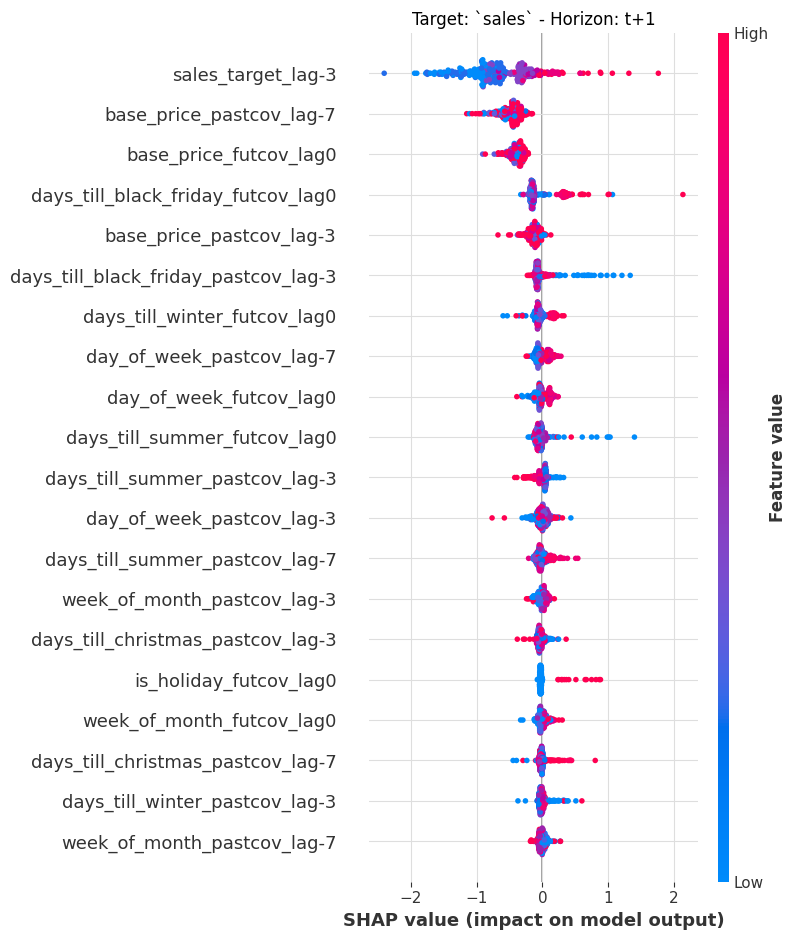

In [6]:

from darts.explainability.shap_explainer import ShapExplainer
shap_explain = ShapExplainer(model,background_series=train_time_series[0],background_future_covariates=future_covariates_series[0],background_past_covariates=past_covariates_series[0])
results = shap_explain.explain()
shap_explain.summary_plot()
shap_explain.force_plot_from_ts()